<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Pytorch-Forecasting</center></span>

<center>Pronóstico de demanda con Temporal Fusion Transformer</center>

<figure>
<center>
<img src="../Imagenes/tutorials_stallion_53_9.png" width="600" height="600" align="center"/>
</center>
</figure>


Fuente: Alvaro Montenegro

##   <span style="color:blue">Profesores</span>

### Coordinador

- Campo Elías Pardo, PhD, cepardot@unal.edu.co

### Conferencistas

- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, Estadístico, ojarmam@unal.edu.co 

##   <span style="color:blue">Asesora Medios y Marketing digital</span>
 

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 

## <span style="color:blue">Asistentes</span>

- Nayibe Yesenia Arias, naariasc@unal.edu.co
- Venus Celeste Puertas, vpuertasg@unal.edu.co 

## <span style="color:blue">Referencias</span>

1. [Alvaro Montenegro y Daniel Montenegro, Inteligencia Artificial y Aprendizaje Profundo, 2021](https://github.com/AprendizajeProfundo/Diplomado)
1. [Alvaro Montenegro, Daniel Montenegro y Oleg Jarma, Inteligencia Artificial y Aprendizaje Profundo Avanzado, 2022](https://github.com/AprendizajeProfundo/Diplomado-Avanzado)
1. [Tutoriales de Pytorch](https://pytorch.org/tutorials/)
1. [Pytorchlightning.ai](https://www.pytorchlightning.ai/)
1. [Tutorial de Pytorch-Forecasting (Temporal Fusion Transformer)](https://pytorch-forecasting.readthedocs.io/en/latest/tutorials/stallion.html)
1. [Lim et. al., Temporal Fusion Transformer](https://arxiv.org/pdf/1912.09363.pdf)

## <span style="color:blue">Contenido</span>

* [Introducción](#Introducción)
* [Instalar Pytorch-Forecasting](#Instalar-Pytorch-Forecasting)
* [Ejemplo de un módulo Forecasting TFT](#Ejemplo-de-un-módulo-Forecasting-TFT)
* [Crea dataset y dataloaders](#Crea-dataset-y-dataloaders)
* [Entrena el modelo](#Entrena-el-modelo) 
* [Búsqueda de mejores hiperparámetros-optuna<](#Búsqueda-de-mejores-hiperparámetros-optuna)
* [Evaluar el desempeño](#Evaluar-el-desempeño)
* [Datos reales frente a predicciones por variables](#Datos-reales-frente-a-predicciones-por-variables)
* [Peores desempeños](#Peores-desempeños)
* [Predicción en datos seleccionados](#Predicción-en-datos-seleccionados)-
* [Predicción con nuevos datos](#Predicción-con-nuevos-datos)
* [Interpretación del  modelo](#Interpretación-del-modelo)


## <span style="color:blue">Introducción</span> 

"El pronóstico de múltiples horizontes a menudo contiene una combinación compleja de entradas, que incluyen
covariables estáticas (es decir, invariantes en el tiempo), entradas futuras conocidas y otras variables exógenas
series de tiempo que solo se observan en el pasado, sin ninguna información previa
sobre cómo interactúan con el objetivo. Varios métodos de aprendizaje profundo han sido
propuestos, pero por lo general son modelos de "caja negra" que no arrojan luz sobre
cómo utilizan la gama completa de insumos presentes en escenarios prácticos. En este documento, presentamos Temporal Fusion Transformer (TFT), una arquitectura novedosa basada en la atención que combina pronósticos multihorizonte de alto rendimiento
con percepciones interpretables de la dinámica temporal. Para aprender las relaciones temporales a diferentes escalas, TFT utiliza capas recurrentes para el procesamiento local y
capas interpretables de autoatención para dependencias a largo plazo. TFT utiliza componentes especializados para seleccionar características relevantes y una serie de capas de activación para
suprimir componentes innecesarios, lo que permite un alto rendimiento en una amplia gama de
escenarios. En una variedad de conjuntos de datos del mundo real, demostramos mejoras de rendimiento significativas sobre los puntos de referencia existentes y mostramos tres prácticas
casos de uso de interpretabilidad de TFT",  [Lim et. al., Temporal Fusion Transformer](https://arxiv.org/pdf/1912.09363.pdf)


En este tutorial, entrenaremos [TemporalFusionTransformer](https://pytorch-forecasting.readthedocs.io/en/latest/api/pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer.html#pytorch_forecasting.models.temporal_fusion_transformer.TemporalFusionTransformer) en un conjunto de datos muy pequeño para demostrar que incluso hace un buen trabajo con solo 20k muestras. En términos generales, es un modelo grande y, por lo tanto, funcionará mucho mejor con más datos.

Nuestro ejemplo es un pronóstico de demanda propueto en  la competencia [Stallion de Kaggle](https://www.kaggle.com/utathya/future-volume-prediction).

## <span style="color:blue">Instalar Pytorch-Forecasting</span> 

En consola ejecute el siguiente comando. 

In [ ]:
#conda install -c conda-forge pytorch-forecasting

## <span style="color:blue">Ejemplo de un módulo Forecasting TFT</span> 

Como ejemplo vamos a implementar un el modelo  `Temporal Fusion Transformer` para los datos [Stallion de Kaggle](https://www.kaggle.com/utathya/future-volume-prediction).

### Imports

In [3]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

### Datos. Lectura inicial

Primero, necesitamos transformar nuestra serie de tiempo en un dataframe de Pandas donde cada fila se puede identificar con un paso de tiempo y una serie de tiempo. Afortunadamente, la mayoría de los conjuntos de datos ya están en este formato. Para este tutorial, utilizaremos el conjunto de datos `Stallion` de Kaggle que describe las ventas de varias bebidas. Nuestra tarea es hacer un pronóstico de seis meses del volumen vendido por unidades de mantenimiento de existencias (SKU), es decir, productos, vendidos por una agencia, es decir, una tienda. Hay alrededor de 21 000 registros históricos de ventas mensuales. Además de las ventas históricas tenemos información sobre el precio de venta, la ubicación de la agencia, días especiales como feriados y volumen vendido en toda la industria.

El conjunto de datos ya está en el formato correcto pero le faltan algunas características importantes. Lo más importante es que debemos agregar un índice de tiempo que se incremente en uno para cada paso de tiempo. Además, es beneficioso agregar funciones de fecha, lo que en este caso significa extraer el mes del registro de fecha.

###  Una nota sobre los códigos SKU

Los códigos SKU o Stock Keeping Unit son uno de los elementos fundamentales para llevar el control y gestionar el stock en la bodega. SKU es el número de referencia único de un producto, según aparece registrado en el sistema de la empresa.

#### ¿Qué características definen a los códigos SKU?

Desgranamos el significado de SKU o Stock Keeping Unit para la gestión de inventarios:

1. Identifica la unidad de venta más pequeña. Por ejemplo, en una empresa de calzado uno de sus códigos SKU podría ser un par de deportivas blancas de la talla 41 de un determinado modelo (y no cada una individualmente, porque no se venden por separado).
1. Un SKU es un código único que está compuesto habitualmente de letras y números. Normalmente, a partir de él se puede inferir a qué producto se refiere, aunque también los hay generados automáticamente por sistemas informatizados que no son tan intuitivos. Siguiendo el ejemplo anterior, un SKU muy básico para un par de deportivas blancas talla 41 modelo XYZ podría ser DEPOR-XYZ-BLN-41.
1. Los códigos SKU son generados por el ERP de la empresa, mientras que el SGA se conecta con él y los gestiona en todas las operaciones del almacén.
1. Los parámetros sobre los que se crea un SKU son definidos a partir de los atributos del producto que se almacena y cada combinación da lugar a un código SKU diferente. La deportiva blanca talla 41 tendrá un SKU, pero la que sea de talla 39 llevará asignado un Stock Keeping Unit distinto.
1. Su finalidad es registrar las características de cada producto almacenado en un lugar determinado. Al representar la unidad almacenada más al detalle, el Stock Keeping Unit permite mayor precisión en el inventario disponible en el almacén y una mejor trazabilidad de las referencias en distintas etapas de la cadena de suministro.
1. Si tenemos varias unidades de la misma referencia, estas compartirán SKU, puesto que son indistintas.
1. Los SKU también se pueden referir a servicios, pero aquí nos centramos en su utilidad para la gestión de inventarios en el almacén.

### Lectura de cada uno de los archivos de datos

In [ ]:
Estos son los datos originales bajados de Kaggle

In [ ]:
#############################

### Train

In [5]:
historical_volume = pd.read_csv('../Datos/archive/train_OwBvO8W/historical_volume.csv')
historical_volume

Agency     SKU  YearMonth      Volume
0      Agency_22  SKU_01     201301    52.27200
1      Agency_22  SKU_02     201301   110.70000
2      Agency_58  SKU_23     201301     0.00000
3      Agency_48  SKU_07     201301    28.32000
4      Agency_22  SKU_05     201301   238.53870
...          ...     ...        ...         ...
20995  Agency_60  SKU_05     201709  1776.99525
20996  Agency_60  SKU_23     201709     1.26000
20997  Agency_60  SKU_04     201709  1142.59575
20998  Agency_32  SKU_02     201709  3456.43200
20999  Agency_32  SKU_05     201709  4174.97025

[21000 rows x 4 columns]

In [6]:
industry_volume = pd.read_csv('../Datos/archive/train_OwBvO8W/industry_volume.csv')
industry_volume

YearMonth  Industry_Volume
0      201301        492612703
1      201302        431937346
2      201303        509281531
3      201304        532390389
4      201305        551755254
5      201306        531683569
6      201307        508376577
7      201308        532480057
8      201309        454252482
9      201310        480693900
10     201311        434960682
11     201312        424138427
12     201401        481364863
13     201402        425528909
14     201403        557166363
15     201404        514349463
16     201405        574689995
17     201406        553838801
18     201407        550644737
19     201408        522726357
20     201409        413051813
21     201410        438831227
22     201411        484133145
23     201412        522571730
24     201501        498567142
25     201502        417947202
26     201503        515468092
27     201504        503173607
28     201505        572293344
29     201506        549967070
30     201507        573927221
31     201508        573733505
32     201509        553979958
33     201510        544203593
34     201511        561516727
35     201512        568138672
36     201601        517389425
37     201602        532697061
38     201603        556542731
39     201604        589172265
40     201605        555318882
41     201606        538687923
42     201607        558020105
43     201608        668934850
44     201609        615784543
45     201610        629490371
46     201611        608313158
47     201612        622509370
48     201701        562154016
49     201702        530252010
50     201703        613143990
51     201704        589969396
52     201705        628759461
53     201706        636846973
54     201707        670015726
55     201708        623319783
56     201709        604571152
57     201710        616747012
58     201711        592195062
59     201712        618073219

In [7]:
demographics = pd.read_csv('../Datos/archive/train_OwBvO8W/demographics.csv')
demographics

Agency  Avg_Population_2017  Avg_Yearly_Household_Income_2017
0   Agency_05              3044268                            182944
1   Agency_02              3137874                            240809
2   Agency_55              2025793                            238553
3   Agency_53              1729177                            111048
4   Agency_50              2057678                            144594
5   Agency_07              1868030                            175785
6   Agency_49              1880416                            154532
7   Agency_46              1709754                            212229
8   Agency_60              2180611                            211936
9   Agency_57              2212416                            187351
10  Agency_51              1750152                            238870
11  Agency_14              2073615                            204289
12  Agency_06              2104390                            228353
13  Agency_56              1901290                            206553
14  Agency_12              1596955                            205376
15  Agency_38              1515841                            173884
16  Agency_48              1739969                            210213
17  Agency_10              1716027                            117463
18  Agency_20              1825752                            102317
19  Agency_09              1646094                            213511
20  Agency_27              1588818                            218862
21  Agency_41              1573238                            125229
22  Agency_58              1620969                            105857
23  Agency_59              1219986                            218902
24  Agency_03              1538040                            217280
25  Agency_16              1232242                            246911
26  Agency_32              1199179                            126063
27  Agency_39              1448423                            131411
28  Agency_13              1520066                            110666
29  Agency_30              1094349                            247220
30  Agency_31               181063                            102731
31  Agency_52               149811                            131764
32  Agency_45               176318                            137609
33  Agency_15               200260                            104564
34  Agency_42               175794                            110057
35  Agency_01               153733                            120207
36  Agency_40               143299                            137912
37  Agency_11               135561                            100461
38  Agency_43               184082                            106262
39  Agency_17               147910                            123013
40  Agency_28                68666                            133669
41  Agency_08                71662                            123610
42  Agency_18                60189                            135477
43  Agency_04                50753                            117957
44  Agency_54                48332                            122313
45  Agency_19                48146                            122042
46  Agency_23                49101                             90240
47  Agency_22                48151                            132110
48  Agency_24                42122                             93027
49  Agency_25                53598                             95032
50  Agency_37                32769                             96761
51  Agency_33                39719                             91375
52  Agency_26                32267                             91330
53  Agency_21                26635                            130092
54  Agency_44                31613                            121781
55  Agency_47                32183                            128574
56  Agency_29                28329                             93614
57  A

In [8]:
event_calendar = pd.read_csv('../Datos/archive/train_OwBvO8W/event_calendar.csv')
event_calendar

YearMonth  Easter Day  Good Friday  New Year  Christmas  Labor Day  \
0      201301           0            0         1          0          0   
1      201302           0            0         0          0          0   
2      201303           1            1         0          0          0   
3      201304           0            0         0          0          0   
4      201305           0            0         0          0          1   
..        ...         ...          ...       ...        ...        ...   
56     201709           0            0         0          0          0   
57     201710           0            0         0          0          0   
58     201711           0            0         0          0          0   
59     201712           0            0         0          1          0   
60     201801           0            0         1          0          0   

    Independence Day  Revolution Day Memorial  Regional Games   \
0                  0                        0                0   
1                  0                        0                0   
2                  0                        0                0   
3                  0                        0                0   
4                  0                        0                0   
..               ...                      ...              ...   
56                 1                        0                0   
57                 0                        0                0   
58                 0                        1                0   
59                 0                        0                0   
60                 0                        0                0   

    FIFA U-17 World Cup  Football Gold Cup  Beer Capital  Music Fest  
0                     0                  0             0           0  
1                     0                  0             0           0  
2                     0                  0             0           1  
3                     0                  0             0           0  
4                     0                  0             0           0  
..                  ...                ...           ...         ...  
56                    0                  0             0           0  
57                    0                  0             0           0  
58                    0                  0             1           0  
59                    0                  0             0           0  
60                    0                  0             0           0  

[61 rows x 13 columns]

In [9]:
industry_soda_sales = pd.read_csv('../Datos/archive/train_OwBvO8W/industry_soda_sales.csv')
industry_soda_sales

YearMonth  Soda_Volume
0      201301    718394219
1      201302    753938444
2      201303    892192092
3      201304    838099501
4      201305    864420003
5      201306    889520921
6      201307    869768947
7      201308    757916529
8      201309    789624076
9      201310    791658684
10     201311    806253783
11     201312    785511080
12     201401    763723622
13     201402    734443953
14     201403    828278650
15     201404    873734739
16     201405    887472626
17     201406    865152191
18     201407    837253085
19     201408    867388593
20     201409    767383003
21     201410    790867324
22     201411    715784335
23     201412    696401477
24     201501    762225057
25     201502    717053984
26     201503    871204688
27     201504    860265890
28     201505    927833877
29     201506    899297932
30     201507    897112934
31     201508    875384686
32     201509    742568762
33     201510    761469815
34     201511    798860058
35     201512    822672453
36     201601    787479774
37     201602    729418593
38     201603    852685632
39     201604    864686985
40     201605    953568835
41     201606    912787084
42     201607    938467950
43     201608    930171702
44     201609    904326556
45     201610    889355958
46     201611    883100473
47     201612    890156001
48     201701    845614054
49     201702    850913048
50     201703    886129111
51     201704    940912941
52     201705    917412482
53     201706    928366256
54     201707    926635433
55     201708   1049868815
56     201709    984438234
57     201710    996763883
58     201711    967899589
59     201712    919709619

In [10]:
price_sales_promotion = pd.read_csv('../Datos/archive/train_OwBvO8W/price_sales_promotion.csv')
price_sales_promotion

Agency     SKU  YearMonth        Price        Sales  Promotions
0      Agency_01  SKU_01     201301  1141.500000  1033.432731  108.067269
1      Agency_01  SKU_01     201302  1141.500000  1065.417195   76.082805
2      Agency_01  SKU_01     201303  1179.345820  1101.133633   78.212187
3      Agency_01  SKU_01     201304  1226.687500  1138.283357   88.404143
4      Agency_01  SKU_01     201305  1230.331104  1148.969634   81.361470
...          ...     ...        ...          ...          ...         ...
20995  Agency_49  SKU_34     201703  1495.906780  1438.732203   57.174577
20996  Agency_49  SKU_34     201705  1495.906780  1499.468196    3.561416
20997  Agency_49  SKU_34     201707  1495.906780  1462.387752   33.519028
20998  Agency_49  SKU_34     201709  1495.906780  1407.814407   88.092373
20999  Agency_49  SKU_34     201712  1501.108475  1507.114831    6.006356

[21000 rows x 6 columns]

In [11]:
weather = pd.read_csv('../Datos/archive/train_OwBvO8W/weather.csv')
weather

YearMonth     Agency  Avg_Max_Temp
0        201301  Agency_01     17.072000
1        201302  Agency_01     19.984000
2        201303  Agency_01     24.600000
3        201304  Agency_01     27.532000
4        201305  Agency_01     29.396000
...         ...        ...           ...
3595     201708  Agency_60     28.417411
3596     201709  Agency_60     27.591111
3597     201710  Agency_60     27.558824
3598     201711  Agency_60     27.674091
3599     201712  Agency_60     23.081069

[3600 rows x 3 columns]

In [12]:
sku_recommendation = pd.read_csv('../Datos/archive/test_8uviCCm/sku_recommendation.csv')
sku_recommendation

Agency  SKU
0  Agency_06  NaN
1  Agency_06  NaN
2  Agency_14  NaN
3  Agency_14  NaN

### Test

In [13]:
volume_forecast = pd.read_csv('../Datos/archive/test_8uviCCm/volume_forecast.csv')
volume_forecast

Agency     SKU  Volume
0     Agency_23  SKU_06     NaN
1     Agency_34  SKU_20     NaN
2     Agency_24  SKU_02     NaN
3     Agency_40  SKU_06     NaN
4     Agency_42  SKU_32     NaN
...         ...     ...     ...
1445  Agency_51  SKU_34     NaN
1446  Agency_37  SKU_03     NaN
1447  Agency_24  SKU_31     NaN
1448  Agency_01  SKU_20     NaN
1449  Agency_20  SKU_05     NaN

[1450 rows x 3 columns]

### Mezcla todas las características que dependen de SKU

In [14]:
sku = historical_volume.merge(price_sales_promotion,on=['Agency','SKU','YearMonth'],how='left')
sku = sku.merge(industry_soda_sales,on=['YearMonth'],how='left')
sku = sku.merge(industry_volume,on='YearMonth',how='left')
sku = sku.merge(event_calendar,on=['YearMonth'],how='left')
print(sku.shape)
sku.head()

(21000, 21)


Agency     SKU  YearMonth    Volume        Price        Sales  \
0  Agency_22  SKU_01     201301   52.2720  1168.903668  1069.166193   
1  Agency_22  SKU_02     201301  110.7000  1167.000000  1067.257500   
2  Agency_58  SKU_23     201301    0.0000     0.000000     0.000000   
3  Agency_48  SKU_07     201301   28.3200  1143.503390  1143.503390   
4  Agency_22  SKU_05     201301  238.5387  1310.176057  1203.875711   

   Promotions  Soda_Volume  Industry_Volume  Easter Day  ...  New Year  \
0   99.737475    718394219        492612703           0  ...         1   
1   99.742500    718394219        492612703           0  ...         1   
2    0.000000    718394219        492612703           0  ...         1   
3    0.000000    718394219        492612703           0  ...         1   
4  106.300346    718394219        492612703           0  ...         1   

   Christmas  Labor Day  Independence Day  Revolution Day Memorial  \
0          0          0                 0                        0   
1          0          0                 0                        0   
2          0          0                 0                        0   
3          0          0                 0                        0   
4          0          0                 0                        0   

   Regional Games   FIFA U-17 World Cup  Football Gold Cup  Beer Capital  \
0                0                    0                  0             0   
1                0                    0                  0             0   
2                0                    0                  0             0   
3                0                    0                  0             0   
4                0                    0                  0             0   

   Music Fest  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 21 columns]

In [15]:
sku.describe().T

count          mean           std           min  \
YearMonth                21000.0  2.015065e+05  1.414669e+02  2.013010e+05   
Volume                   21000.0  1.492404e+03  2.711497e+03  0.000000e+00   
Price                    21000.0  1.451536e+03  6.833624e+02  0.000000e+00   
Sales                    21000.0  1.267347e+03  5.877573e+02 -3.121690e+03   
Promotions               21000.0  1.843741e+02  2.574700e+02  0.000000e+00   
Soda_Volume              21000.0  8.512000e+08  7.824340e+07  6.964015e+08   
Industry_Volume          21000.0  5.439214e+08  6.288022e+07  4.130518e+08   
Easter Day               21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Good Friday              21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
New Year                 21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Christmas                21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Labor Day                21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Independence Day         21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Revolution Day Memorial  21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Regional Games           21000.0  1.666667e-02  1.280221e-01  0.000000e+00   
FIFA U-17 World Cup      21000.0  0.000000e+00  0.000000e+00  0.000000e+00   
Football Gold Cup        21000.0  0.000000e+00  0.000000e+00  0.000000e+00   
Beer Capital             21000.0  8.333333e-02  2.763920e-01  0.000000e+00   
Music Fest               21000.0  8.333333e-02  2.763920e-01  0.000000e+00   

                                  25%           50%           75%  \
YearMonth                2.014038e+05  2.015065e+05  2.016092e+05   
Volume                   8.272388e+00  1.584360e+02  1.774793e+03   
Price                    1.311547e+03  1.495175e+03  1.725652e+03   
Sales                    1.178366e+03  1.324696e+03  1.517311e+03   
Promotions               5.493511e+01  1.383072e+02  2.722986e+02   
Soda_Volume              7.890880e+08  8.649196e+08  9.005551e+08   
Industry_Volume          5.090553e+08  5.512000e+08  5.893715e+08   
Easter Day               0.000000e+00  0.000000e+00  0.000000e+00   
Good Friday              0.000000e+00  0.000000e+00  0.000000e+00   
New Year                 0.000000e+00  0.000000e+00  0.000000e+00   
Christmas                0.000000e+00  0.000000e+00  0.000000e+00   
Labor Day                0.000000e+00  0.000000e+00  0.000000e+00   
Independence Day         0.000000e+00  0.000000e+00  0.000000e+00   
Revolution Day Memorial  0.000000e+00  0.000000e+00  0.000000e+00   
Regional Games           0.000000e+00  0.000000e+00  0.000000e+00   
FIFA U-17 World Cup      0.000000e+00  0.000000e+00  0.000000e+00   
Football Gold Cup        0.000000e+00  0.000000e+00  0.000000e+00   
Beer Capital             0.000000e+00  0.000000e+00  0.000000e+00   
Music Fest               0.000000e+00  0.000000e+00  0.000000e+00   

                                  max  
YearMonth                2.017120e+05  
Volume                   2.252661e+04  
Price                    1.916662e+04  
Sales                    4.925404e+03  
Promotions               1.916662e+04  
Soda_Volume              1.049869e+09  
Industry_Volume          6.700157e+08  
Easter Day               1.000000e+00  
Good Friday              1.000000e+00  
New Year                 1.000000e+00  
Christmas                1.000000e+00  
Labor Day                1.000000e+00  
Independence Day         1.000000e+00  
Revolution Day Memorial  1.000000e+00  
Regional Games           1.000000e+00  
FIFA U-17 World Cup      0.000000e+00  
Football Gold Cup        0.000000e+00  
Beer Capital             1.000000e+00  
Music Fest               1.000000e+00

### Mezcla todas las caraterísticas que dependen de Agency

In [16]:
agency = weather.merge(demographics,on=['Agency'],how='left')
print(agency.shape)
agency.head()

(3600, 5)


YearMonth     Agency  Avg_Max_Temp  Avg_Population_2017  \
0     201301  Agency_01        17.072               153733   
1     201302  Agency_01        19.984               153733   
2     201303  Agency_01        24.600               153733   
3     201304  Agency_01        27.532               153733   
4     201305  Agency_01        29.396               153733   

   Avg_Yearly_Household_Income_2017  
0                            120207  
1                            120207  
2                            120207  
3                            120207  
4                            120207

In [17]:
agency.describe().T

count           mean            std  \
YearMonth                         3600.0  201506.500000     141.483134   
Avg_Max_Temp                      3600.0      28.722767       4.021126   
Avg_Population_2017               3600.0  936716.616667  913185.544533   
Avg_Yearly_Household_Income_2017  3600.0  148119.333333   50188.108577   

                                            min            25%            50%  \
YearMonth                         201301.000000  201403.750000  201506.500000   
Avg_Max_Temp                          16.731034      25.581118      28.648529   
Avg_Population_2017                12271.000000   50340.000000  647304.500000   
Avg_Yearly_Household_Income_2017   90240.000000  106160.750000  129333.000000   

                                           75%           max  
YearMonth                         2.016092e+05  2.017120e+05  
Avg_Max_Temp                      3.167674e+01  4.529048e+01  
Avg_Population_2017               1.719314e+06  3.137874e+06  
Avg_Yearly_Household_Income_2017  2.045608e+05  2.472200e+05

In [ ]:
### Mezcla todo el dataset y se prepara para entrenamiento

In [18]:
df = sku.merge(agency,on=['YearMonth','Agency'],how='left')
print(df.shape)
df.head()


(21000, 24)


Agency     SKU  YearMonth    Volume        Price        Sales  \
0  Agency_22  SKU_01     201301   52.2720  1168.903668  1069.166193   
1  Agency_22  SKU_02     201301  110.7000  1167.000000  1067.257500   
2  Agency_58  SKU_23     201301    0.0000     0.000000     0.000000   
3  Agency_48  SKU_07     201301   28.3200  1143.503390  1143.503390   
4  Agency_22  SKU_05     201301  238.5387  1310.176057  1203.875711   

   Promotions  Soda_Volume  Industry_Volume  Easter Day  ...  \
0   99.737475    718394219        492612703           0  ...   
1   99.742500    718394219        492612703           0  ...   
2    0.000000    718394219        492612703           0  ...   
3    0.000000    718394219        492612703           0  ...   
4  106.300346    718394219        492612703           0  ...   

   Independence Day  Revolution Day Memorial  Regional Games   \
0                 0                        0                0   
1                 0                        0                0   
2                 0                        0                0   
3                 0                        0                0   
4                 0                        0                0   

   FIFA U-17 World Cup  Football Gold Cup  Beer Capital  Music Fest  \
0                    0                  0             0           0   
1                    0                  0             0           0   
2                    0                  0             0           0   
3                    0                  0             0           0   
4                    0                  0             0           0   

   Avg_Max_Temp  Avg_Population_2017  Avg_Yearly_Household_Income_2017  
0     25.845238                48151                            132110  
1     25.845238                48151                            132110  
2     22.219737              1620969                            105857  
3     24.052893              1739969                            210213  
4     25.845238                48151                            132110  

[5 rows x 24 columns]

In [ ]:
#############################

In [19]:
data = df
data.columns

Index(['Agency', 'SKU', 'YearMonth', 'Volume', 'Price', 'Sales', 'Promotions',
       'Soda_Volume', 'Industry_Volume', 'Easter Day', 'Good Friday',
       'New Year', 'Christmas', 'Labor Day', 'Independence Day',
       'Revolution Day Memorial', 'Regional Games ', 'FIFA U-17 World Cup',
       'Football Gold Cup', 'Beer Capital', 'Music Fest', 'Avg_Max_Temp',
       'Avg_Population_2017', 'Avg_Yearly_Household_Income_2017'],
      dtype='object')

#### Cambia nombres de columnas por comodidad

In [20]:
new_names = ['agency', 'sku', 'year_month', 'volume', 'price_regular', 'sales', 'promotions',
             'soda_volume', 'industry_volume', "easter_day",  "good_friday",  "new_year",
             "christmas", "labor_day", "independence_day", "revolution_day_memorial", 
             "regional_games", "fifa_u_17_world_cup", "football_gold_cup",
             "beer_capital", "music_fest", 
             'avg_max_temp', 'avg_population_2017', 'avg_yearly_household_income_2017']
data.columns = new_names

### Guarda los datos construidos

In [21]:
data.to_csv('../Datos/archive/train_OwBvO8W/stalion.csv')

#### Crea un índice de fechas en el dataframe

In [42]:
import numpy as np
year = data['year_month']
agno = np.array([int(str(y)[:4]) for y in year])
mes = np.array([int(str(y)[4:]) for y in year])
time_index = agno * 12 + mes
time_index -= np.min(time_index)

data["time_idx"] = time_index 
data['month'] = mes.astype(str)
data['year'] = agno.astype(str)

In [44]:
data.describe().T

count          mean           std  \
year_month                        21000.0  2.015065e+05  1.414669e+02   
volume                            21000.0  1.492404e+03  2.711497e+03   
price_regular                     21000.0  1.451536e+03  6.833624e+02   
sales                             21000.0  1.267347e+03  5.877573e+02   
promotions                        21000.0  1.843741e+02  2.574700e+02   
soda_volume                       21000.0  8.512000e+08  7.824340e+07   
industry_volume                   21000.0  5.439214e+08  6.288022e+07   
avg_max_temp                      21000.0  2.861240e+01  3.972833e+00   
avg_population_2017               21000.0  1.045065e+06  9.291926e+05   
avg_yearly_household_income_2017  21000.0  1.510735e+05  5.040959e+04   
time_idx                          21000.0  2.950000e+01  1.731851e+01   
log_volume                        21000.0  2.464118e+00  8.178218e+00   
avg_volume_by_sku                 21000.0  1.492404e+03  1.051791e+03   
avg_volume_by_agency              21000.0  1.492404e+03  1.328240e+03   
discount_in_percent               21000.0  1.057488e-01  9.590813e-02   

                                           min           25%           50%  \
year_month                        2.013010e+05  2.014038e+05  2.015065e+05   
volume                            0.000000e+00  8.272388e+00  1.584360e+02   
price_regular                     0.000000e+00  1.311547e+03  1.495175e+03   
sales                            -3.121690e+03  1.178366e+03  1.324696e+03   
promotions                        0.000000e+00  5.493511e+01  1.383072e+02   
soda_volume                       6.964015e+08  7.890880e+08  8.649196e+08   
industry_volume                   4.130518e+08  5.090553e+08  5.512000e+08   
avg_max_temp                      1.673103e+01  2.537482e+01  2.847927e+01   
avg_population_2017               1.227100e+04  6.018900e+04  1.232242e+06   
avg_yearly_household_income_2017  9.024000e+04  1.100570e+05  1.314110e+05   
time_idx                          0.000000e+00  1.475000e+01  2.950000e+01   
log_volume                       -1.842068e+01  2.112923e+00  5.065351e+00   
avg_volume_by_sku                 0.000000e+00  9.322855e+02  1.402305e+03   
avg_volume_by_agency              0.000000e+00  1.134203e+02  1.730530e+03   
discount_in_percent               0.000000e+00  3.749628e-02  8.948990e-02   

                                           75%           max  
year_month                        2.016092e+05  2.017120e+05  
volume                            1.774793e+03  2.252661e+04  
price_regular                     1.725652e+03  1.916662e+04  
sales                             1.517311e+03  4.925404e+03  
promotions                        2.722986e+02  1.916662e+04  
soda_volume                       9.005551e+08  1.049869e+09  
industry_volume                   5.893715e+08  6.700157e+08  
avg_max_temp                      3.156840e+01  4.529048e+01  
avg_population_2017               1.729177e+06  3.137874e+06  
avg_yearly_household_income_2017  2.065530e+05  2.472200e+05  
time_idx                          4.425000e+01  5.900000e+01  
log_volume                        7.481439e+00  1.002245e+01  
avg_volume_by_sku                 2.195362e+03  4.332364e+03  
avg_volume_by_agency              2.595316e+03  5.884717e+03  
discount_in_percent               1.564706e-01  2.267401e+00

In [24]:
data.dtypes

agency                               object
sku                                  object
year_month                            int64
volume                              float64
price_regular                       float64
sales                               float64
promotions                          float64
soda_volume                           int64
industry_volume                       int64
easter_day                            int64
good_friday                           int64
new_year                              int64
christmas                             int64
labor_day                             int64
independence_day                      int64
revolution_day_memorial               int64
regional_games                        int64
fifa_u_17_world_cup                   int64
football_gold_cup                     int64
beer_capital                          int64
music_fest                            int64
avg_max_temp                        float64
avg_population_2017             

#### Agrega características adicionales

In [25]:
# Agrega características adicionales
data["month"] = data['month'].astype("category")  # categorias deben ser strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")


# queremos codificar días especiales como una variable y, por lo tanto, 
# primero debemos revertir la codificación one-hot
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

data["discount_in_percent"] = data["promotions"].values / data["price_regular"].values
data["discount_in_percent"] = data["discount_in_percent"].fillna(0)

/tmp/ipykernel_4574/37454873.py:27: RuntimeWarning: invalid value encountered in true_divide
  data["discount_in_percent"] = data["promotions"].values / data["price_regular"].values


## <span style="color:blue">Crea dataset y dataloaders</span> 

El siguiente paso es convertir el marco de datos en un PyTorch Forecasting `TimeSeriesDataSet`. Además de decirle al conjunto de datos qué características son categóricas o continuas y cuáles son estáticas o variables en el tiempo, también tenemos que decidir cómo normalizamos los datos.

Aquí, escalamos cada serie de tiempo por separado e indicamos que los valores son siempre positivos. En general, se prefiere el `EncoderNormalizer`, que se escala dinámicamente en cada secuencia del codificador a medida que entrena, para evitar el sesgo de anticipación inducido por la normalización.

Sin embargo, se puede aceptar el sesgo de anticipación si tiene problemas para encontrar una normalización razonablemente estable, por ejemplo, porque hay muchos ceros en sus datos. O espera una normalización más estable en la inferencia. En el último caso, se asegura de no aprender saltos "extraños" que no estarán presentes cuando se ejecuta la inferencia, por lo que se entrena en un conjunto de datos más realista.

También optamos por utilizar los últimos seis meses como conjunto de validación.

In [29]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # mantenga la longitud del codificador larga (como está en el conjunto de validación)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # grupo de variables categóricas puede tratarse como una variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# crear un conjunto de validación (predict=True) que significa predecir los últimos puntos max_prediction_length en el tiempo
# para cada serie
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# crea dataloaders para el modelo
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)


## <span style="color:blue">Define el trainer</span> 

In [27]:
# define el trainer con early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=1, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    gradient_clip_val=0.05,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## <span style="color:blue">Crea el modelo</span> 

In [30]:
# crea el modelo
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7,
    loss=QuantileLoss(),
    log_interval=2,
    reduce_on_plateau_patience=4
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 98.1k


/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


### Encuentra la rata optimal de aprendizaje

/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (30

suggested learning rate: 6.644821791421809e-08


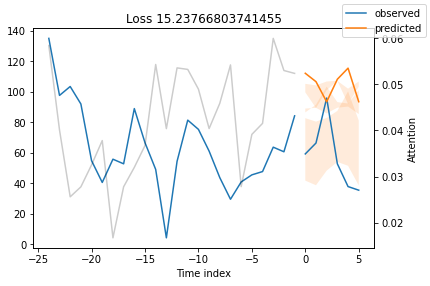

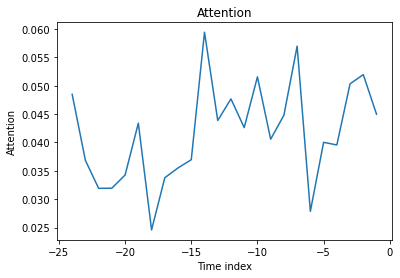

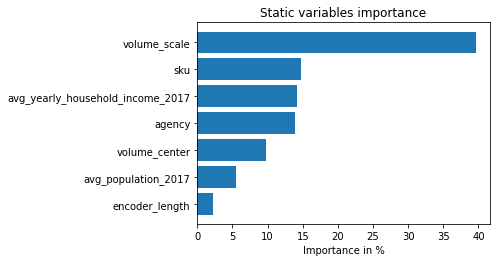

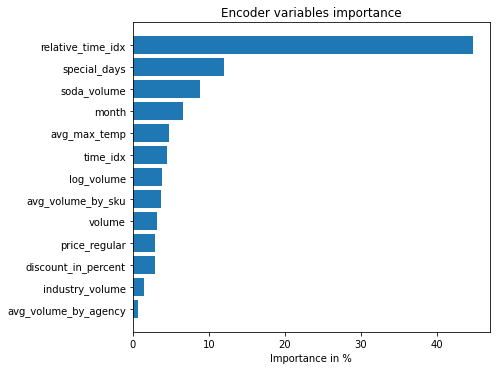

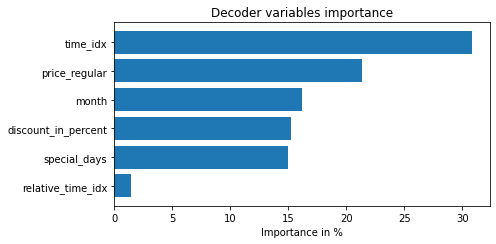

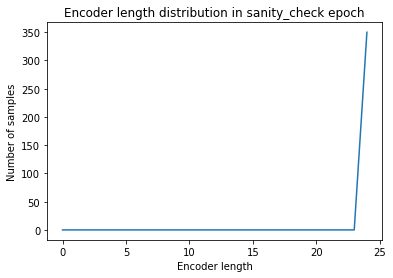

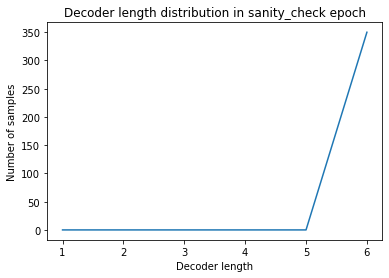

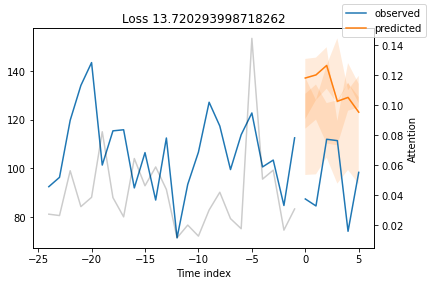

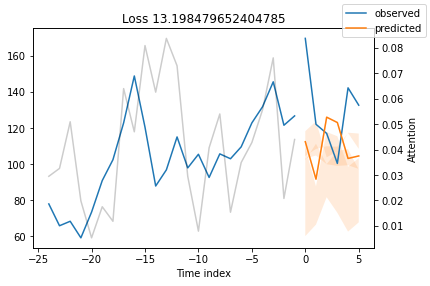

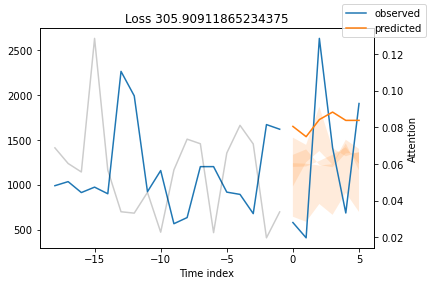

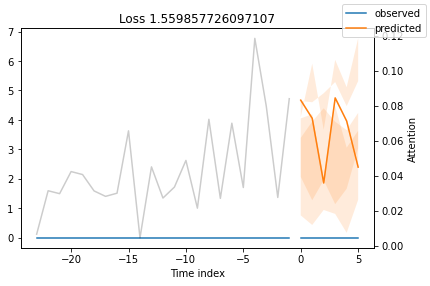

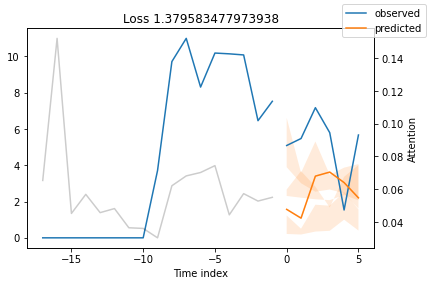

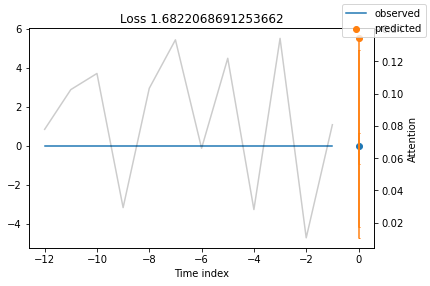

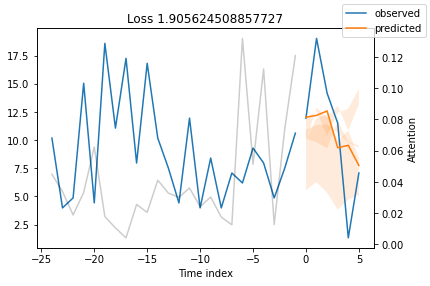

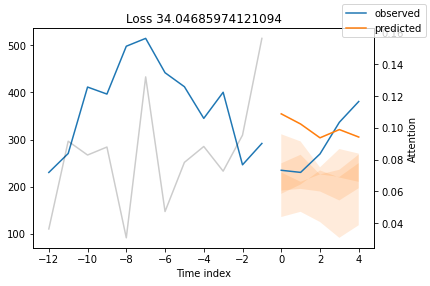

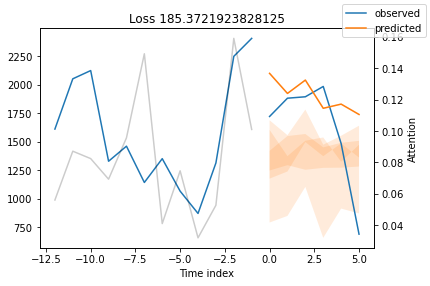

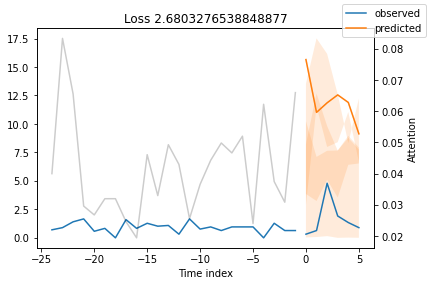

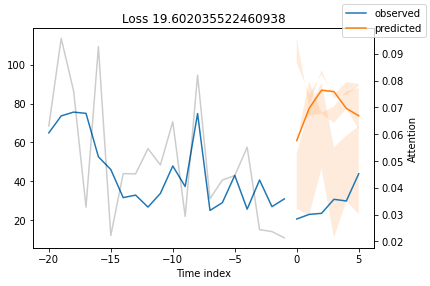

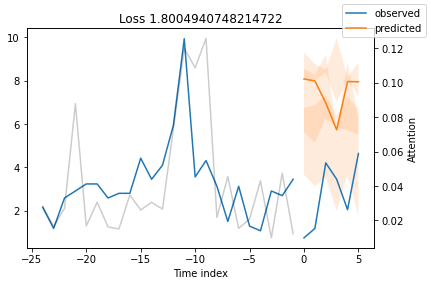

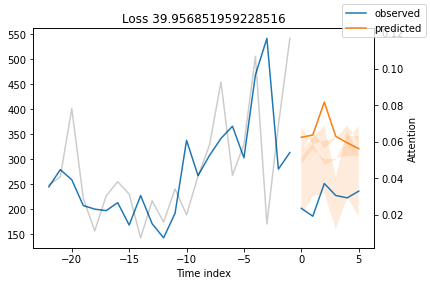

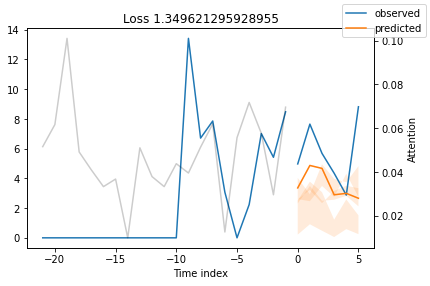

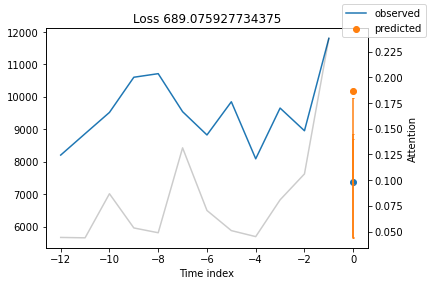

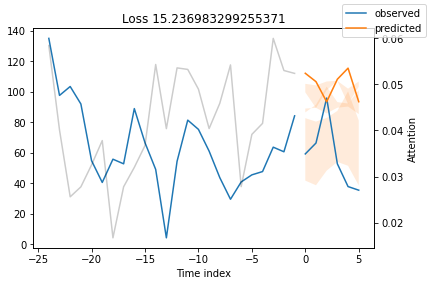

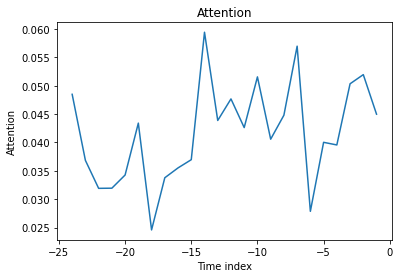

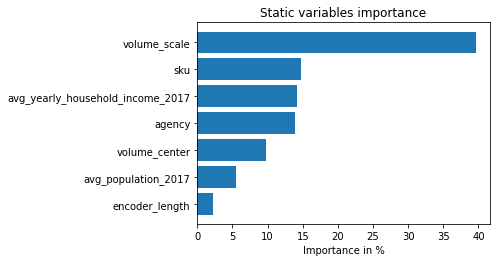

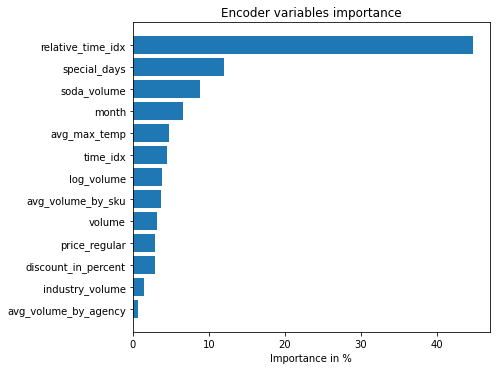

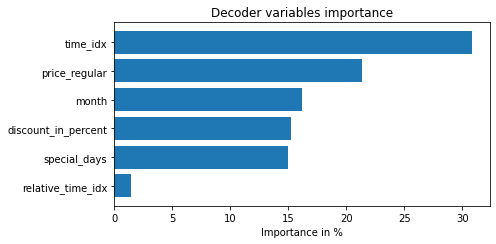

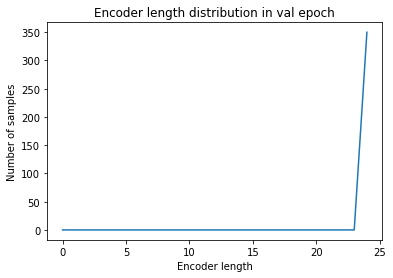

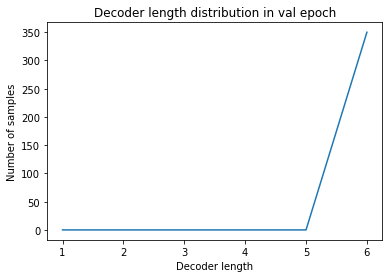

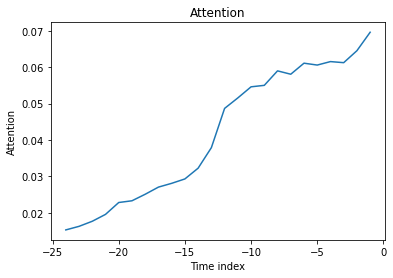

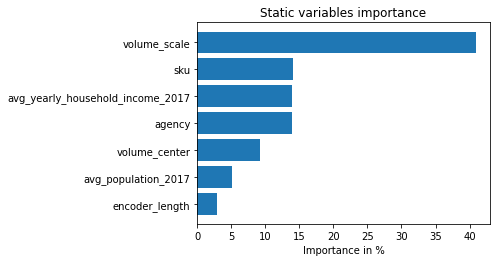

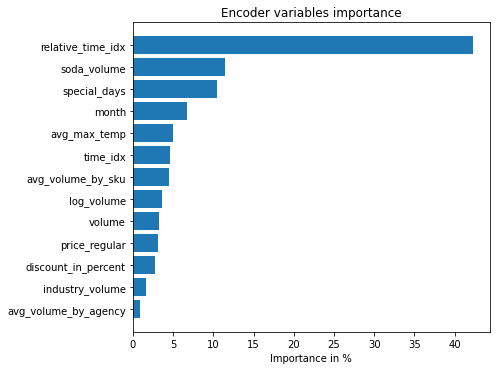

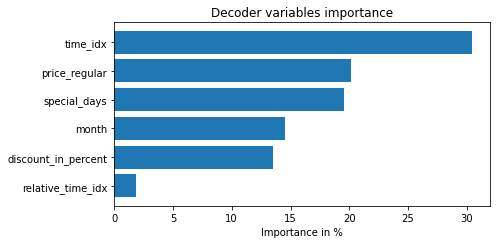

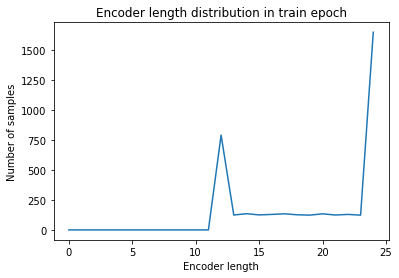

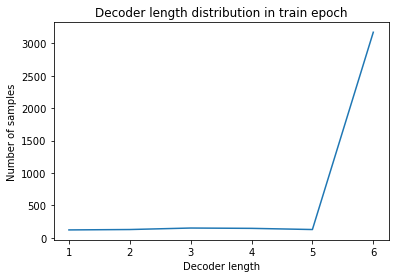

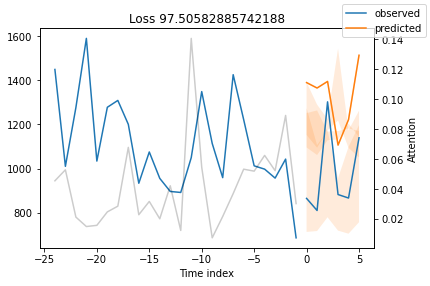

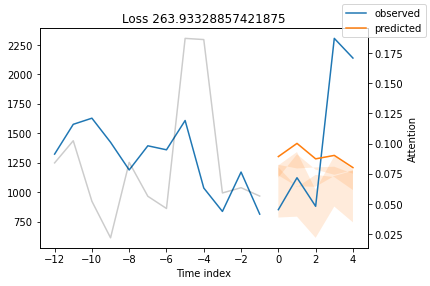

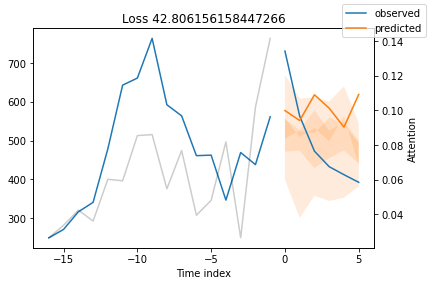

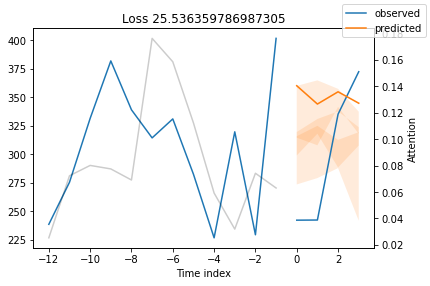

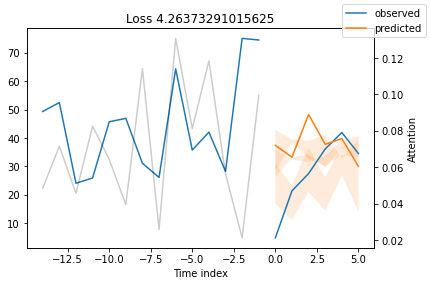

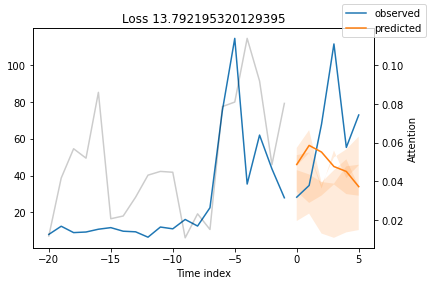

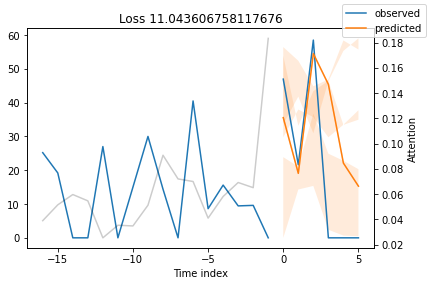

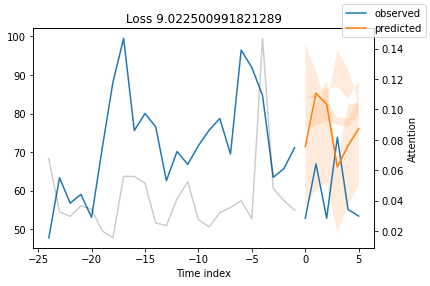

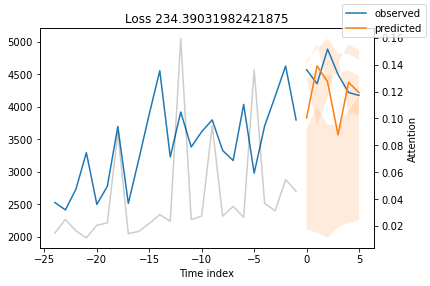

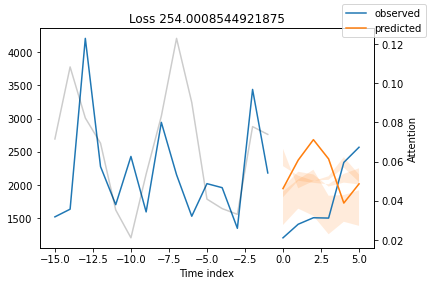

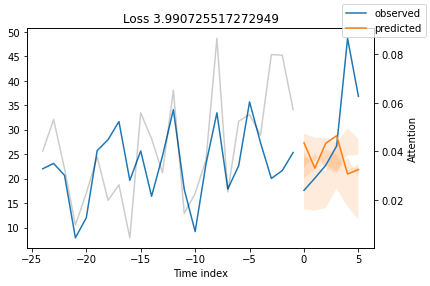

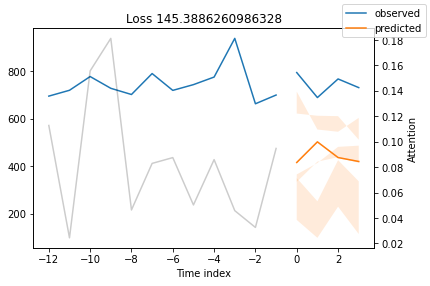

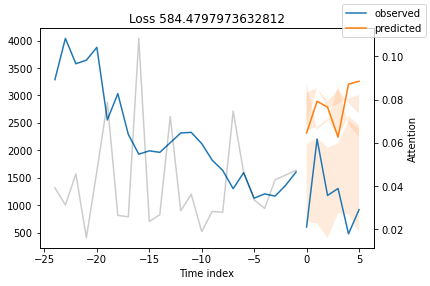

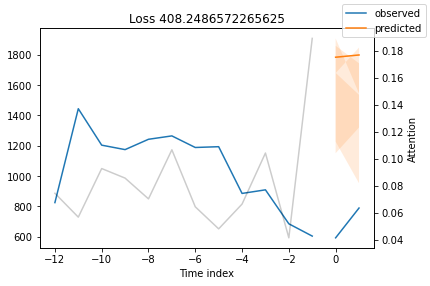

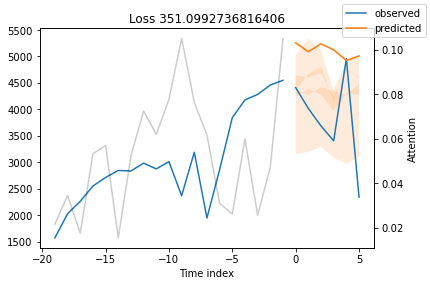

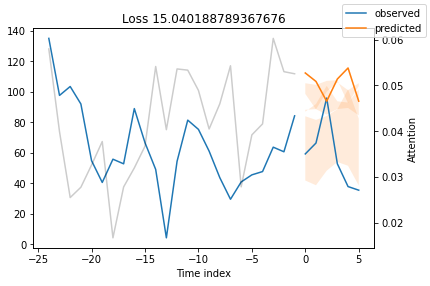

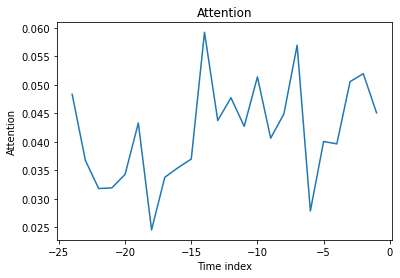

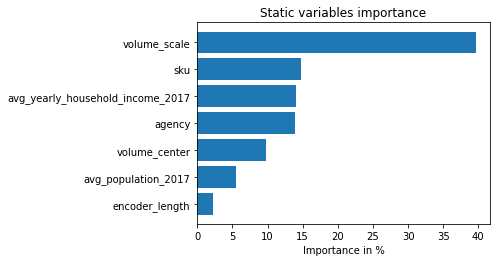

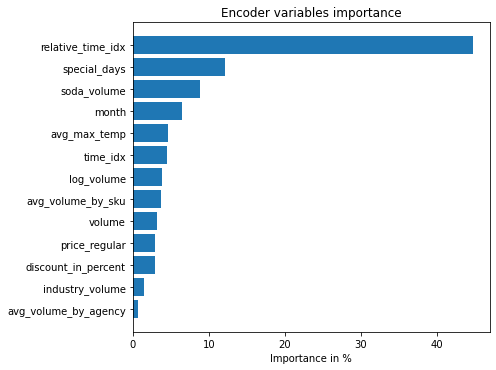

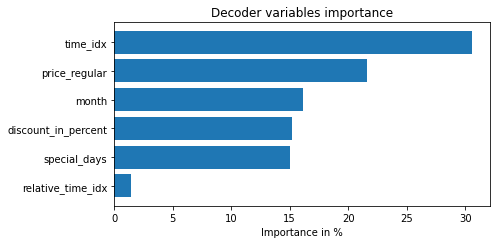

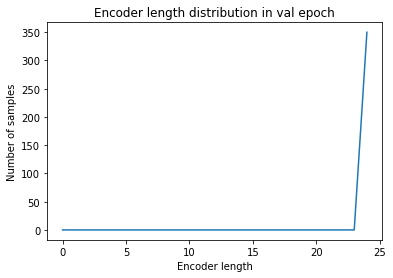

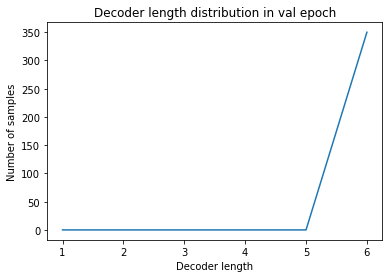

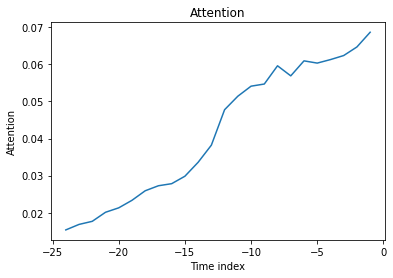

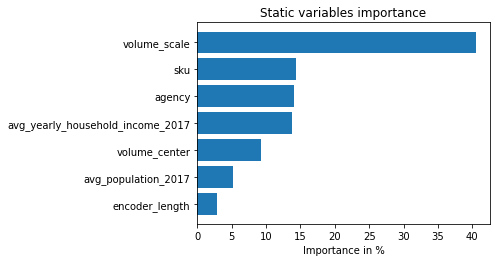

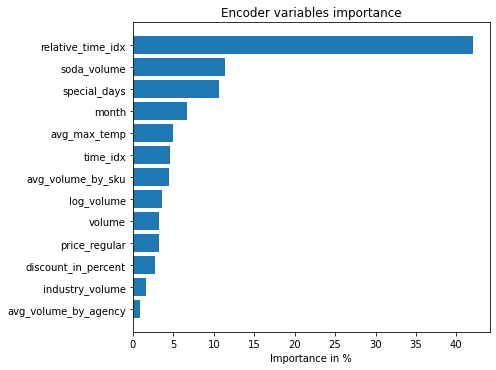

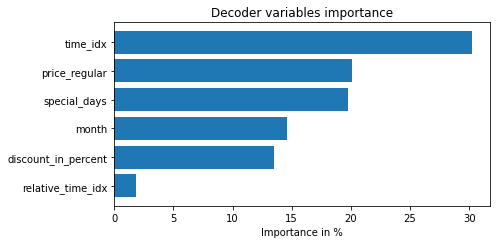

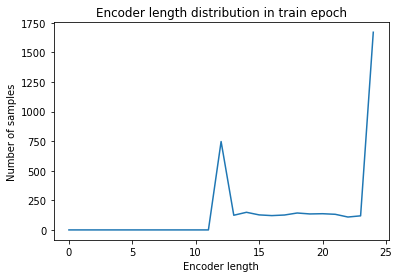

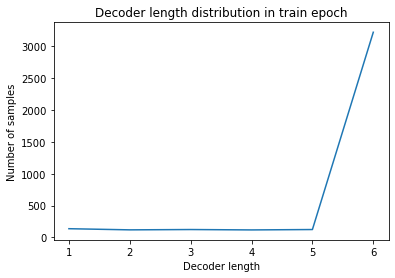

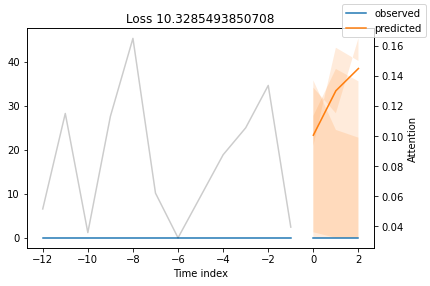

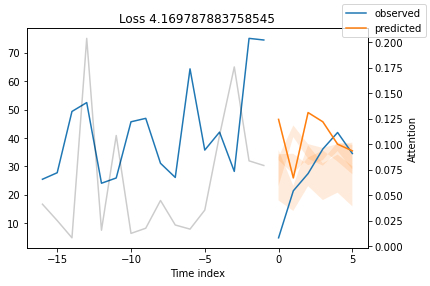

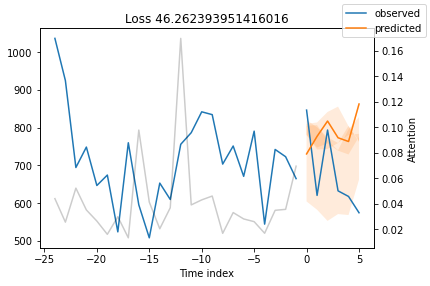

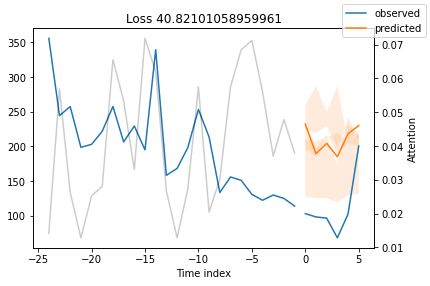

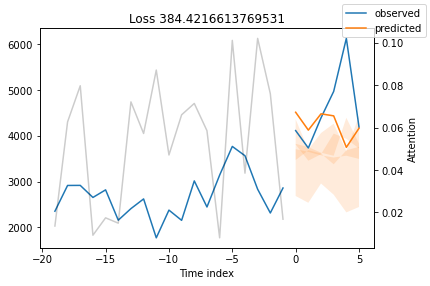

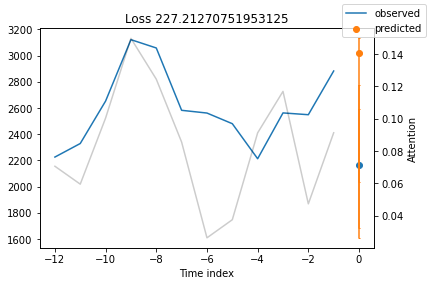

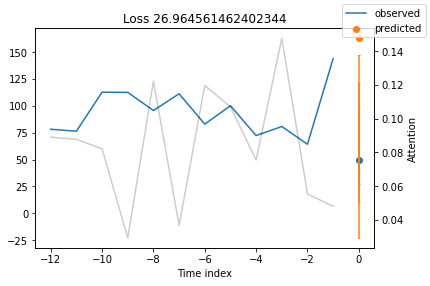

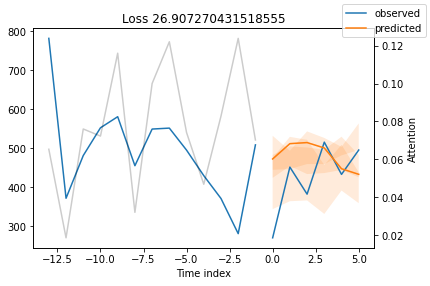

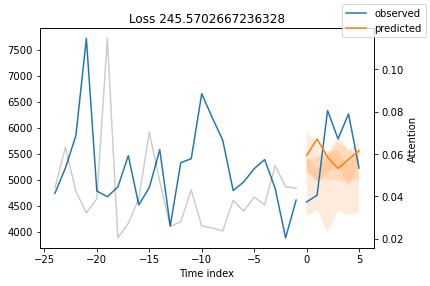

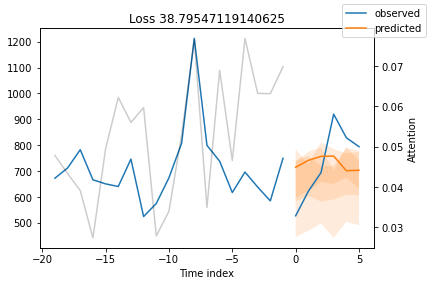

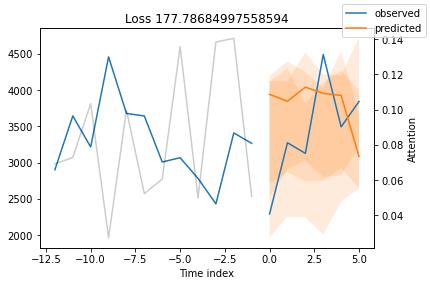

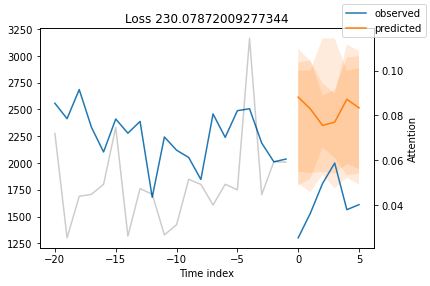

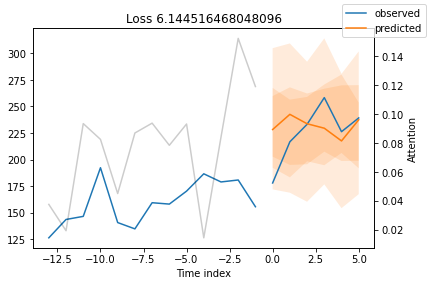

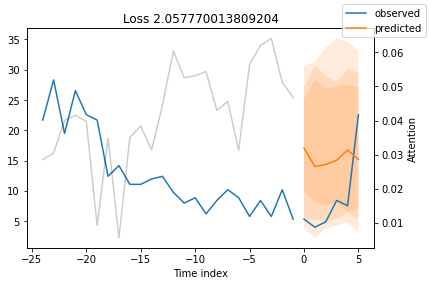

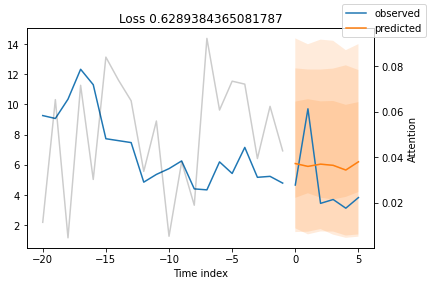

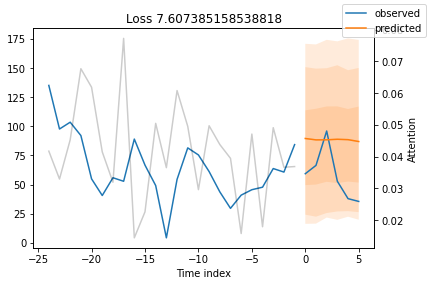

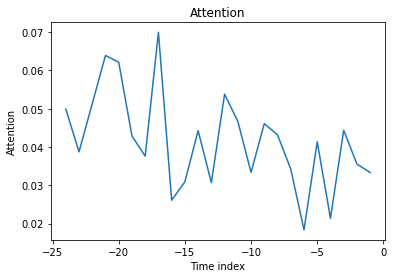

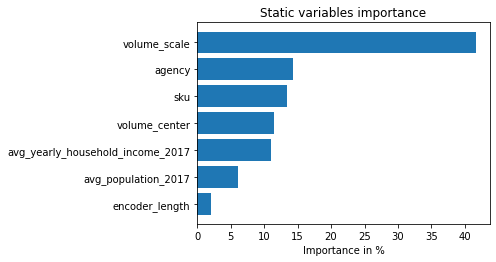

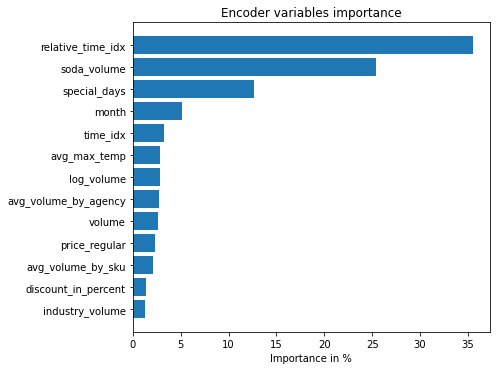

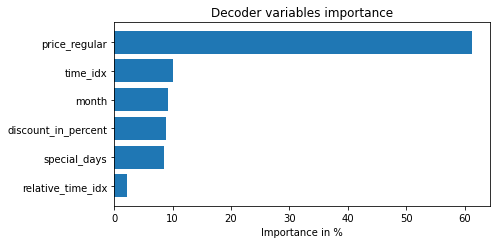

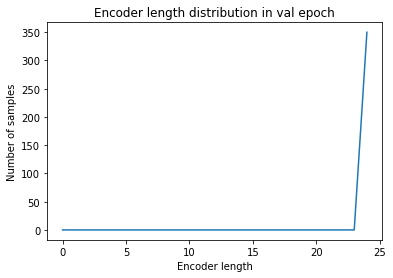

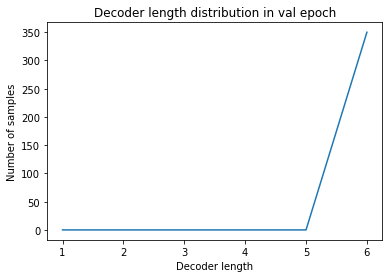

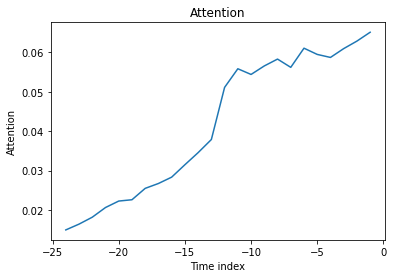

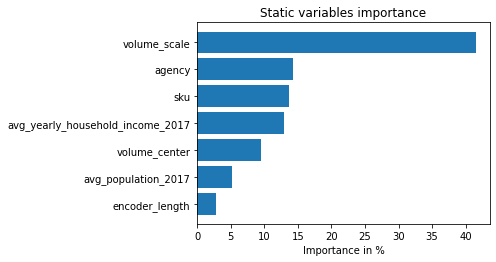

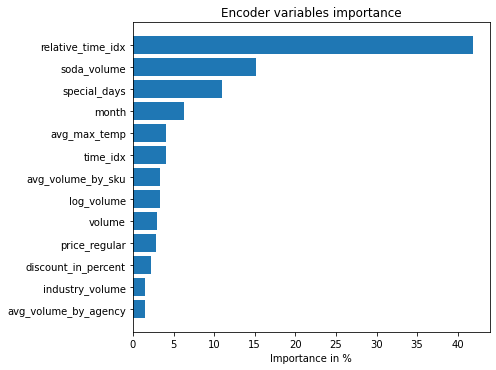

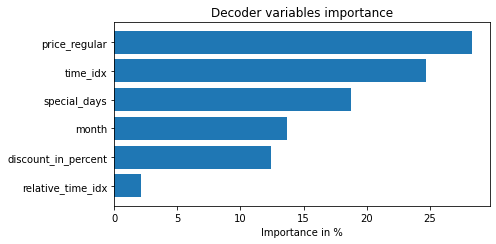

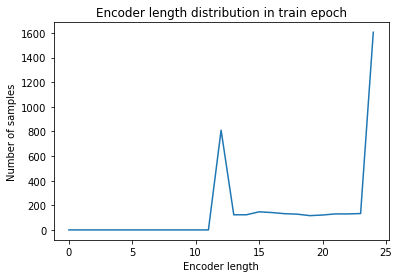

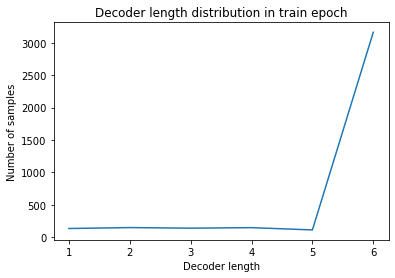

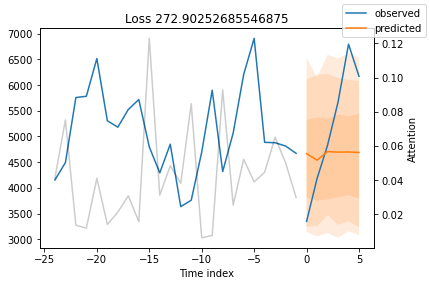

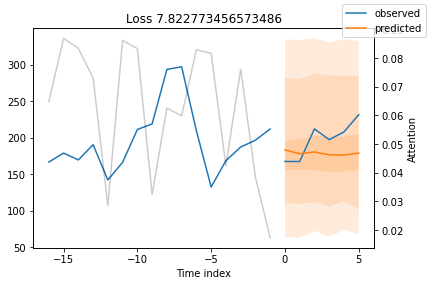

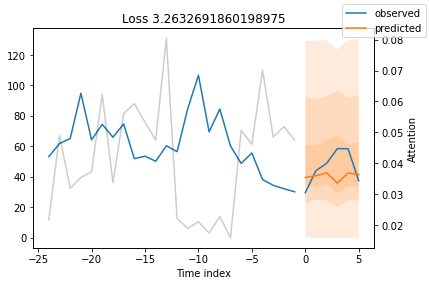

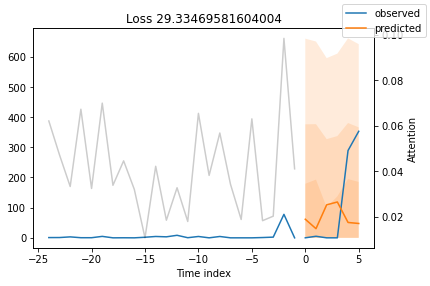

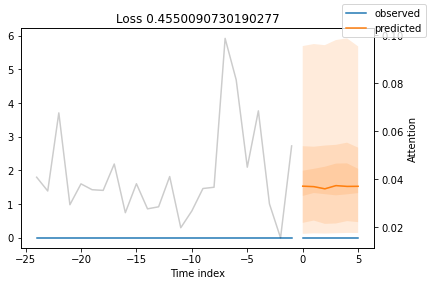

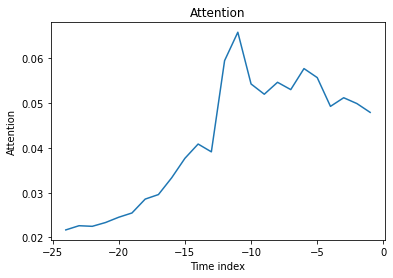

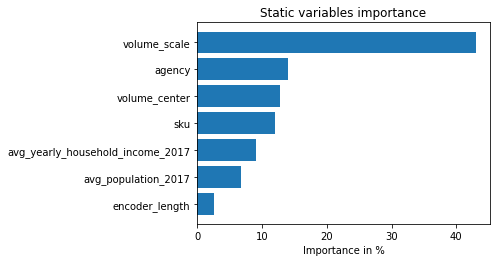

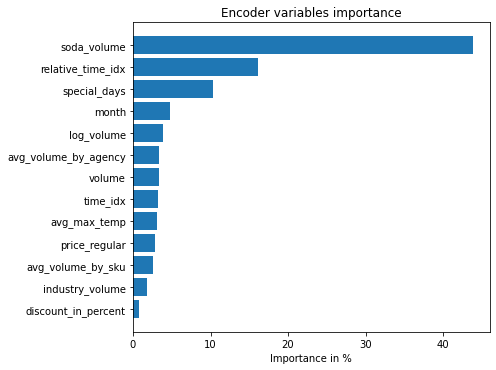

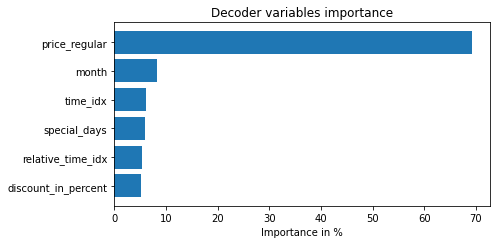

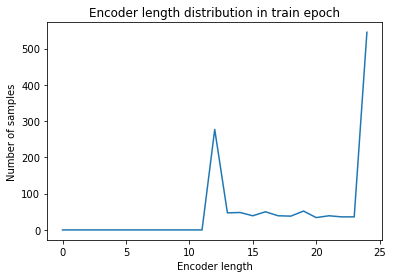

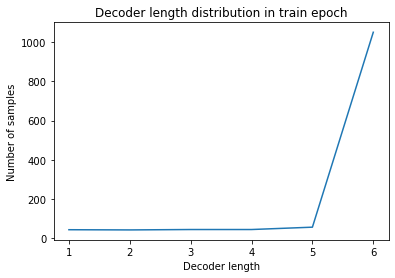

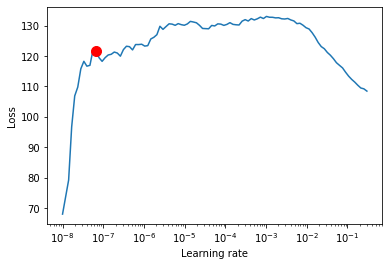

/tmp/ipykernel_28447/2236248710.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [47]:
# find optimal learning rate (set limit_train_batches to 1.0 and log_interval = -1)
res = trainer.tuner.lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## <span style="color:blue">Entrena el modelo</span>  

In [31]:
# fit the model
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

Missing logger folder: /home/alvaro/Documents/AprendizajeProfundo/Diplomado_UNAL/Diplomado-master/Temas/Módulo 15- Pytorch/Cuadernos/lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 512   
4  | static_variable_selection          | VariableSelectionNetwork        | 10.3 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 23.7 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.3 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_con

/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1938: PossibleUserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:  97%|▉| 30/31 [00:17<00:00,  1.67it/s, loss=89.1, v_num=0, train_loss_s
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 0: 100%|█| 31/31 [00:20<00:00,  1.54it/s, loss=89.1, v_num=0, train_loss_s
Epoch 1:  97%|▉| 30/31 [00:38<00:01,  1.29s/it, loss=70.7, v_num=0, train_loss_s
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 1: 100%|█| 31/31 [00:41<00:00,  1.33s/it, loss=70.7, v_num=0, train_loss_s
Epoch 2:  97%|▉| 30/31 [01:00<00:02,  2.03s/it, loss=71.2, v_num=0, train_loss_s
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [00:00<?, ?it/s]
Epoch 2: 100%|█| 31/31 [01:03<00:00,  2.04s/it, loss=71.2, v_num=0, train_loss_s
Epoch 3:  97%|▉| 30/31 [01:22<00:02,  2.76s/it, loss=61, v_num=0, train_loss_ste
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   0%|                            | 0/1 [0

## <span style="color:blue">Búsqueda de mejores hiperparámetros-optuna</span> 

El ajuste de hiperparámetros con [optuna](https://optuna.org/) está integrado directamente en pytorch-forecasting. Por ejemplo, podemos usar la funciónOptimize_hyperparameters() para optimizar los hiperparámetros de la TFT.

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("../Datos/test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

## <span style="color:blue">Evaluar el desempeño</span> 

PyTorch Lightning verifica automáticamente el entrenamiento de checkpoints y, por lo tanto, podemos recuperar fácilmente el mejor modelo y cargarlo.

In [32]:
# carga el mejor modelo según la pérdida de validación
# (dado que usamos la parada anticipada, esta no es necesariamente la última época)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:244: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [33]:
# calcular el error absoluto medio en el conjunto de validación
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(279.9411)

Ahora también podemos ver predicciones de muestra directamente que trazamos con plot_prediction(). Como puede ver en las cifras a continuación, los pronósticos parecen bastante precisos. Si se pregunta, las líneas grises indican la cantidad de atención que el modelo presta a diferentes puntos en el tiempo al hacer la predicción. Esta es una característica especial del Transformador de Fusión Temporal.

In [36]:
# las predicciones sin procesar son un diccionario del que se puede extraer todo tipo de información, incluidos los cuantiles
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

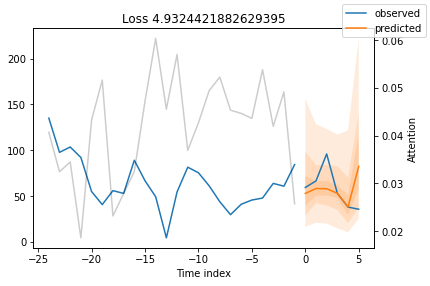

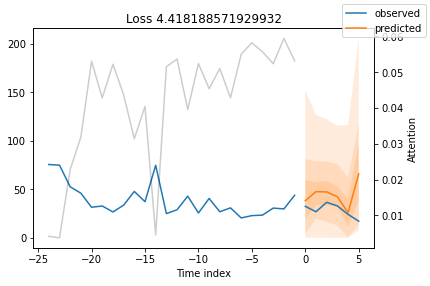

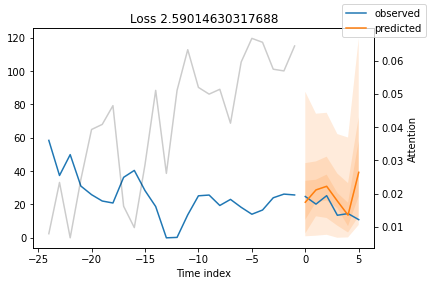

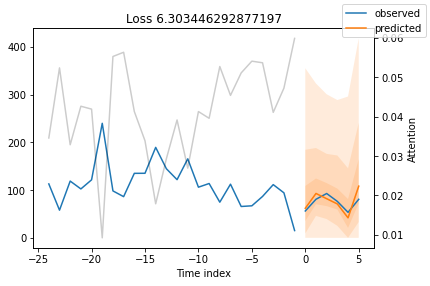

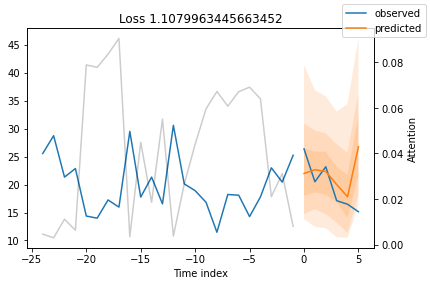

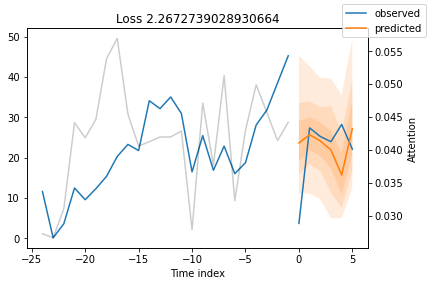

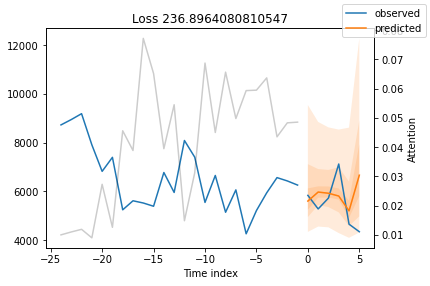

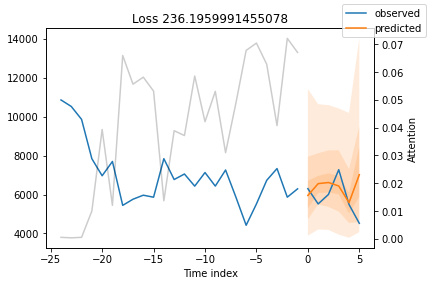

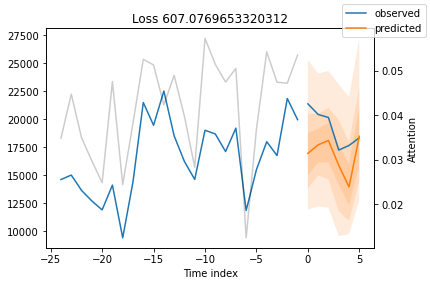

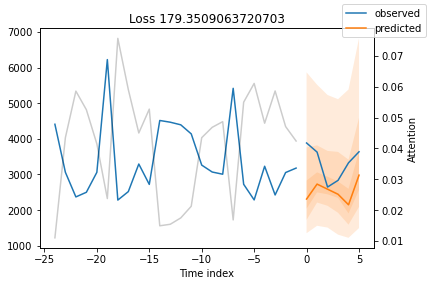

In [37]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

## <span style="color:blue">Peores desempeños</span> 

Observar a los peores, por ejemplo, en términos de SMAPE, nos da una idea de dónde el modelo tiene problemas para realizar pronósticos de manera confiable. Estos ejemplos pueden proporcionar indicaciones importantes sobre cómo mejorar el modelo. Este tipo de gráficos de datos reales frente a predicciones están disponibles para todos los modelos. Por supuesto, también es sensato emplear métricas adicionales, como MASE, definidas en el módulo de métricas. Sin embargo, por el bien de la demostración, aquí solo usamos SMAPE.

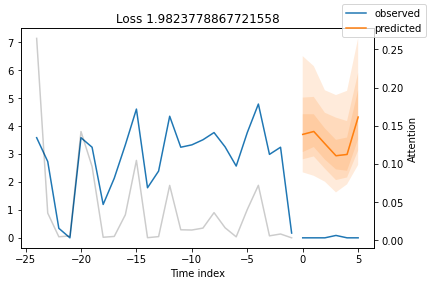

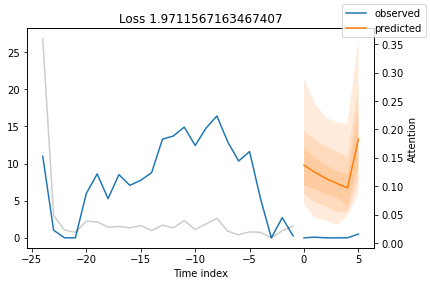

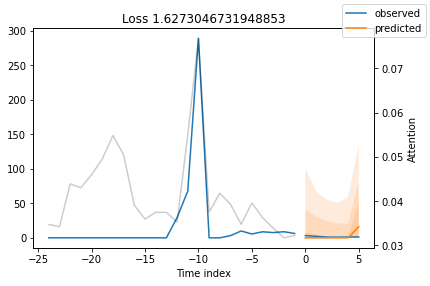

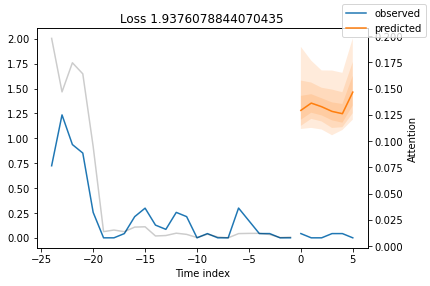

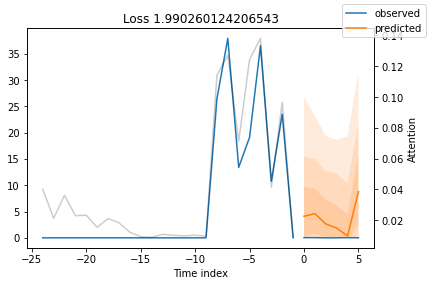

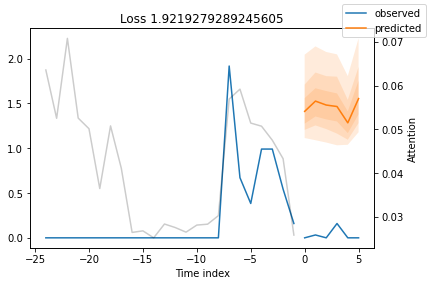

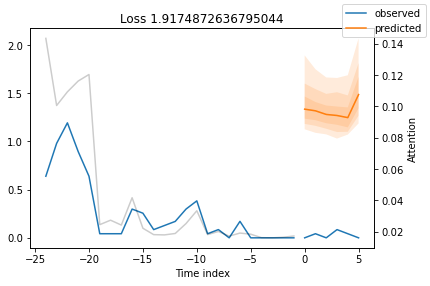

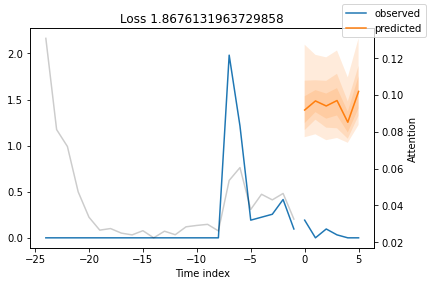

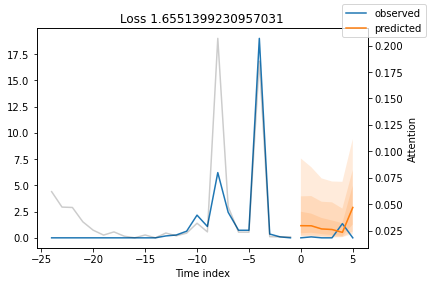

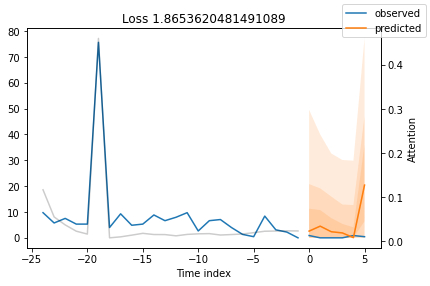

In [38]:
# calcula metrica y la dibuja
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

## <span style="color:blue">Datos reales frente a predicciones por variables</span> 


Verificar cómo funciona el modelo en diferentes segmentos de los datos nos permite detectar debilidades. A continuación, se representan gráficamente los medios de las predicciones frente a los valores reales de cada variable dividida en 100 contenedores mediante el Ahora, podemos predecir directamente sobre los datos generados utilizando los métodos de calcular_predicción_actual_por_variable() y trazar_predicción_actual_por_variable(). Las barras grises denotan la frecuencia de la variable por bin, es decir, son un histograma

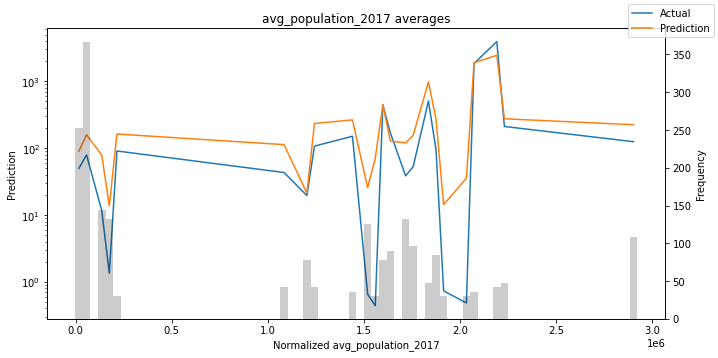

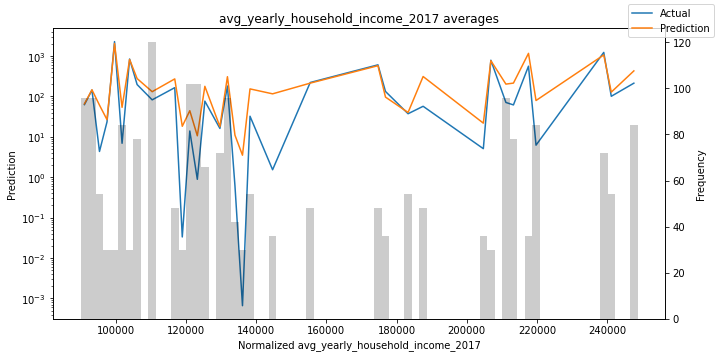

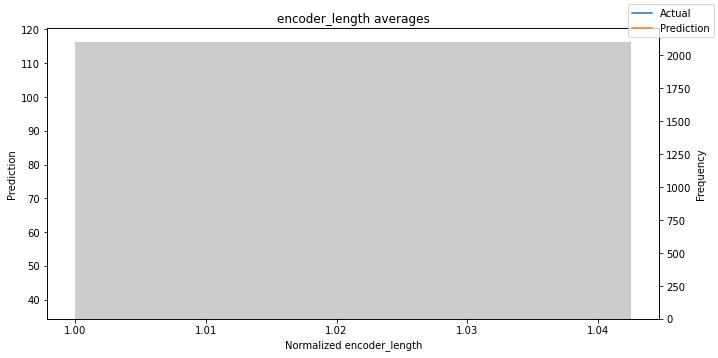

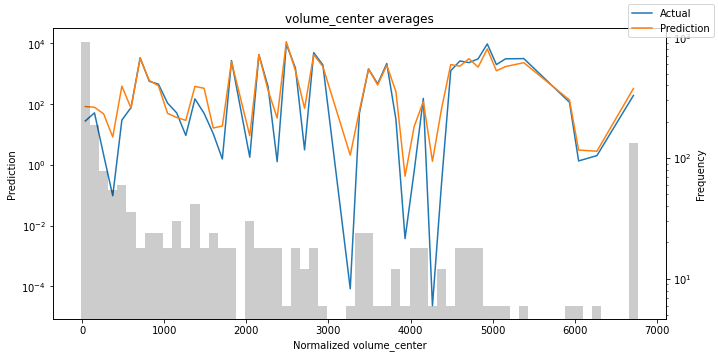

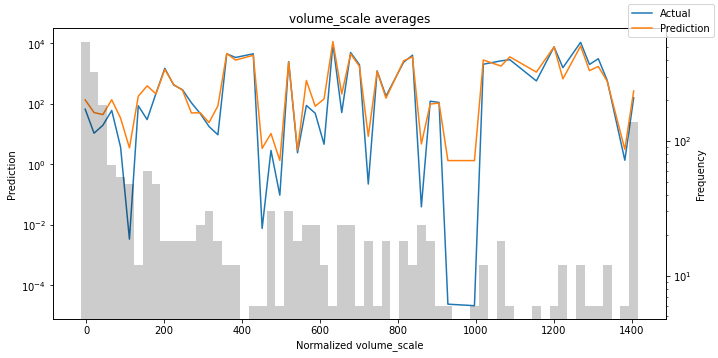

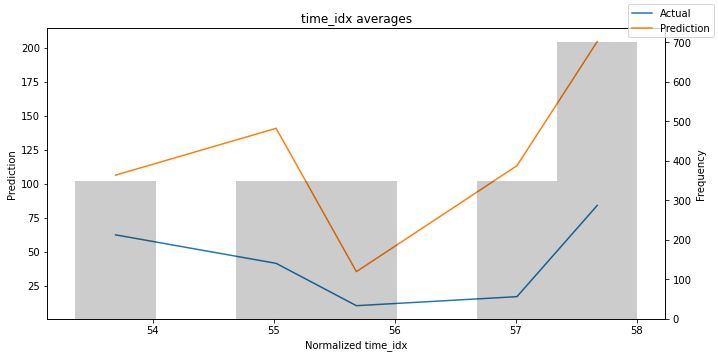

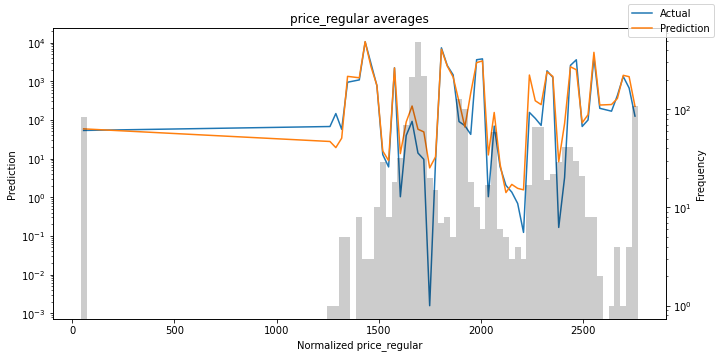

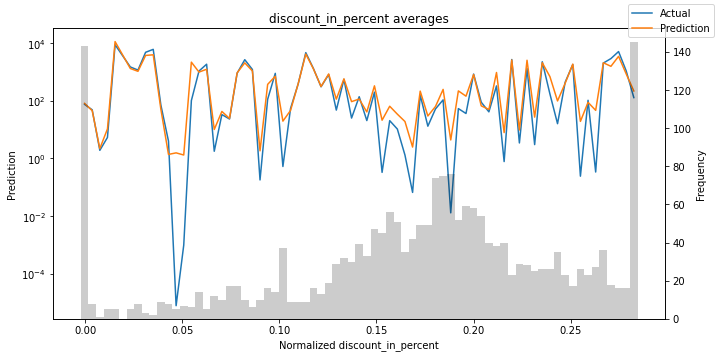

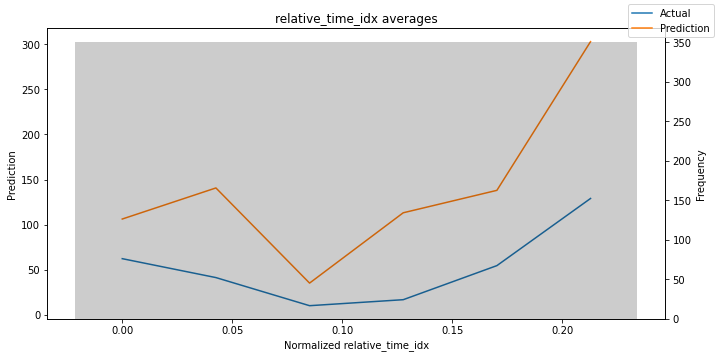

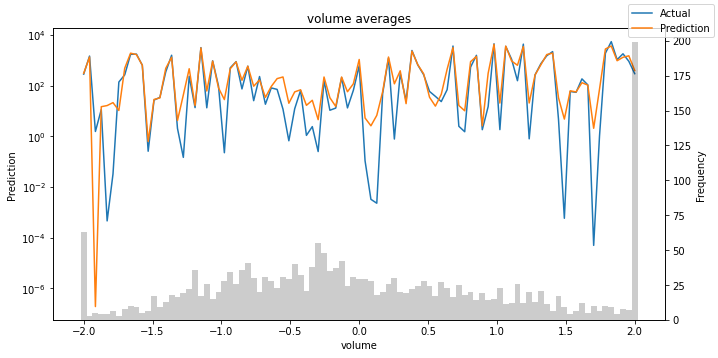

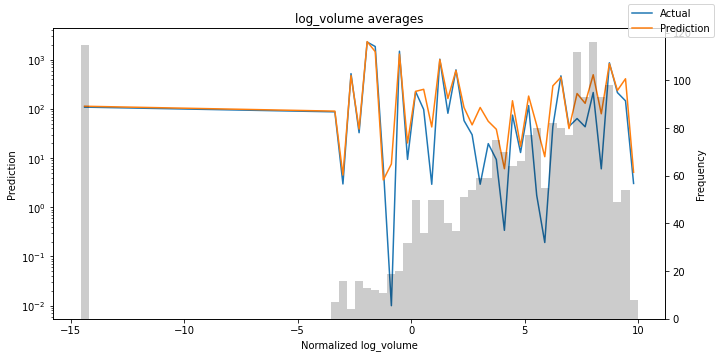

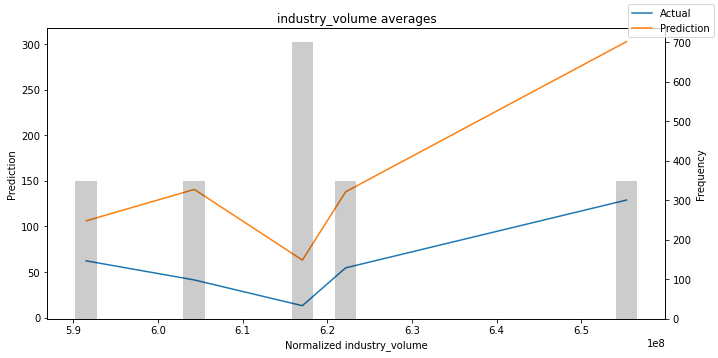

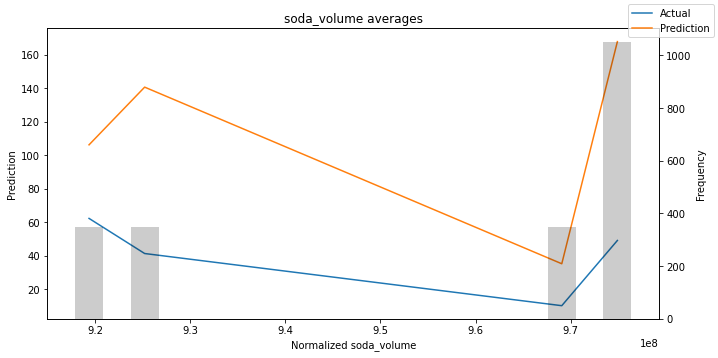

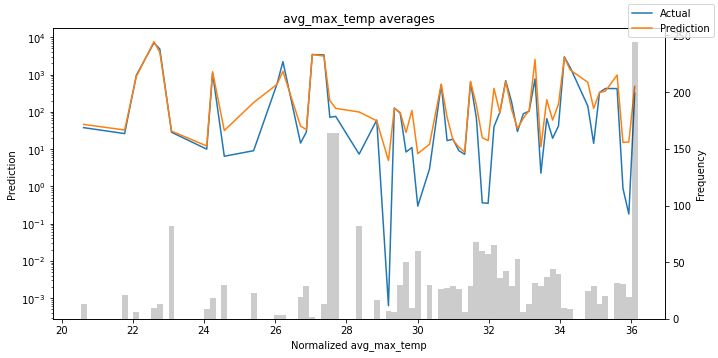

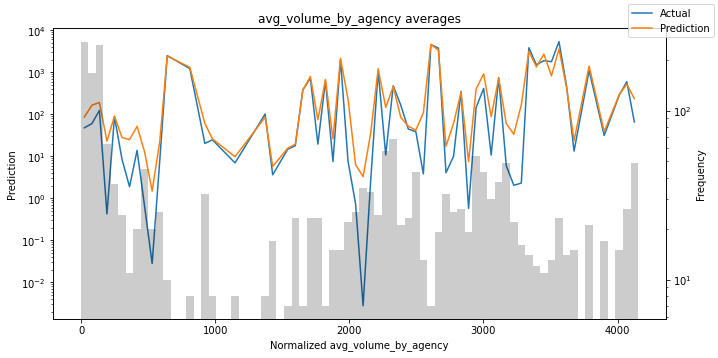

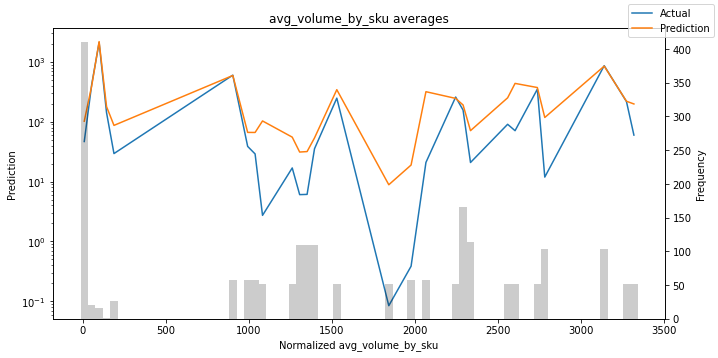

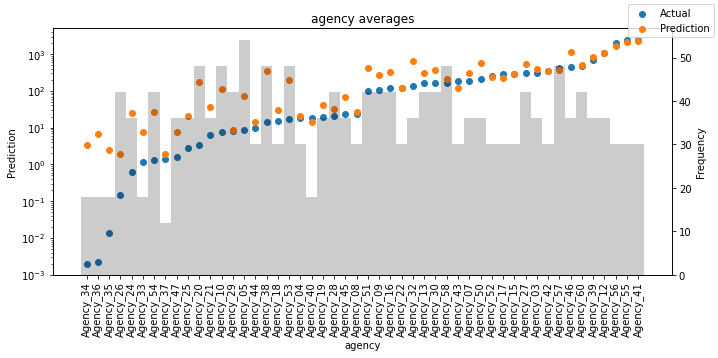

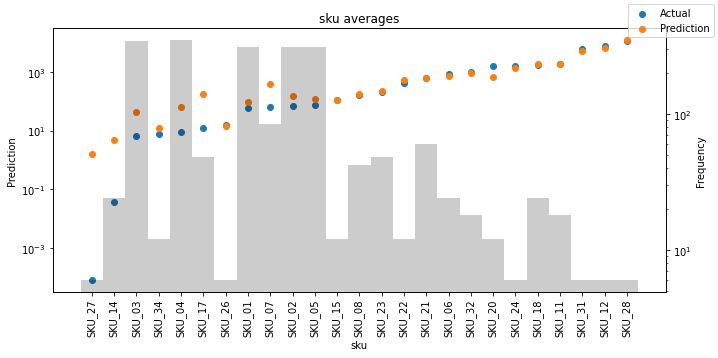

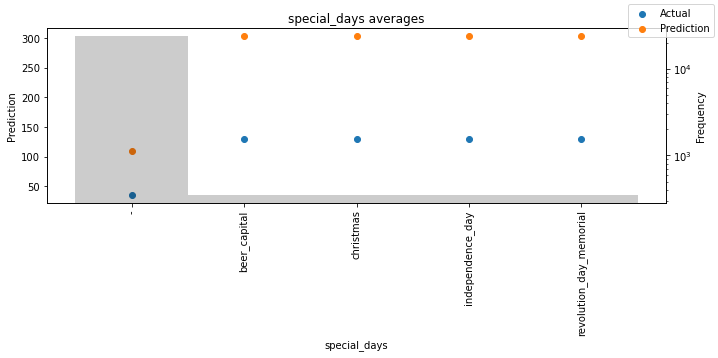

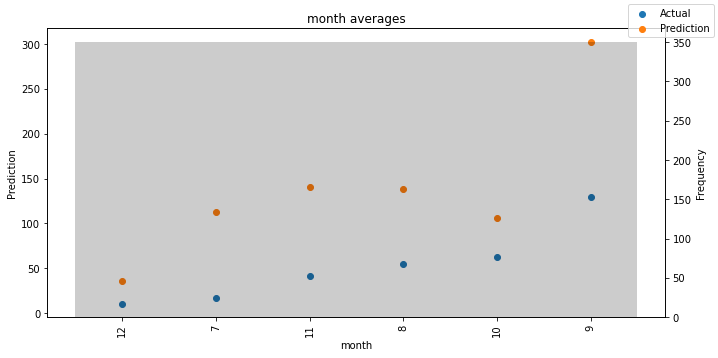

In [39]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## <span style="color:blue">Predicción en datos seleccionados</span> 


Para predecir sobre un subconjunto de datos, podemos filtrar las subsecuencias en un conjunto de datos utilizando el método filter(). Aquí predecimos la subsecuencia en el conjunto de datos de entrenamiento que se asigna a los ID de grupo "Agency_01" y "SKU_01" y cuyo primer valor predicho corresponde al índice de tiempo "15". Damos salida a los siete cuantiles. Esto significa que esperamos un tensor de forma 1 x n_timesteps x n_quantiles = 1 x 6 x 7 como predecimos para una sola subsecuencia seis pasos de tiempo por delante y 7 cuantiles para cada paso de tiempo.

best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

In [ ]:
Por supuesto, también podemos dibujar esta predicción fácilmente:

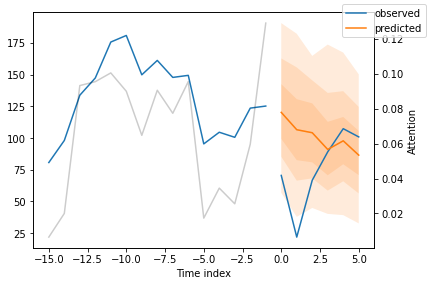

In [40]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

## <span style="color:blue"> Predicción con nuevos datos</span>



Debido a que tenemos covariables en el conjunto de datos, predecir con nuevos datos requiere que definamos las covariables conocidas por adelantado. 

In [41]:
# seleccione los últimos 24 meses de los datos (max_encoder_length es 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# seleccione el último punto de datos conocido y cree datos de decodificador a partir de él repitiéndolo e incrementando el mes
# en un conjunto de datos del mundo real, no deberíamos simplemente completar las covariables, sino especificarlas para tener en cuenta
# para cambios en días especiales y precios (que absolutamente deberías hacer, pero somos demasiado flojos aquí)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# agregar índice de tiempo consistente con "datos"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# ajustar funciones adicionales de tiempo
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combinar datos de codificador y decodificador
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'date'

Ahora, podemos predecir directamente sobre los datos generados usando el método predict().

In [ ]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

## <span style="color:blue"> Interpretación del  modelo</span>

Datos reales frente a predicciones por variables
Peores desempeños
Predicción en datos seleccionados
Predicción con nuevos datos
Interpretación del  modelo

### Importancia de las  variables

El modelo tiene capacidades de interpretación incorporadas debido a cómo se construye su arquitectura. Veamos cómo se ve eso. Primero calculamos las interpretaciones con *interpret_output()* y luego las trazamos con *plot_interpretation()*.

{'attention': <Figure size 432x288 with 1 Axes>,
 'static_variables': <Figure size 504x270 with 1 Axes>,
 'encoder_variables': <Figure size 504x378 with 1 Axes>,
 'decoder_variables': <Figure size 504x252 with 1 Axes>}

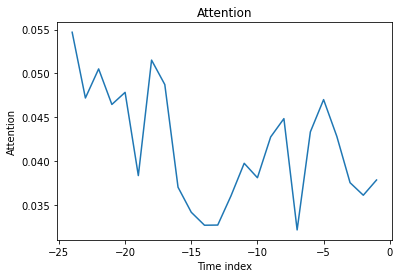

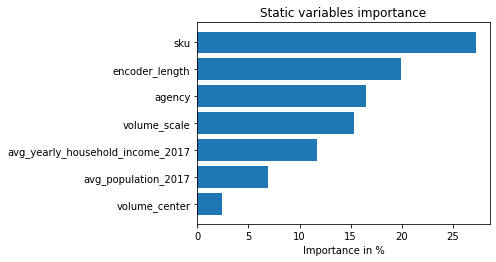

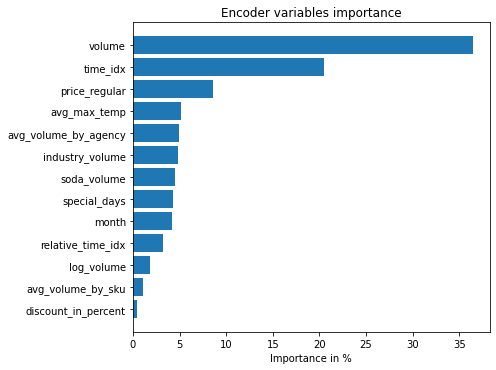

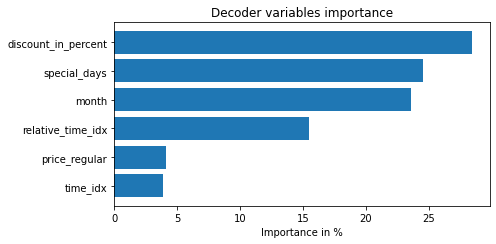

In [45]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Como era de esperar, las funciones de volumen observadas en el pasado como la variable principal en el codificador y las variables relacionadas con el precio se encuentran entre los principales predictores en el decodificador.

Los patrones generales de atención parecen ser que las observaciones más recientes son más importantes y más antiguas. Esto confirma la intuición. La atención promedio a menudo no es muy útil: mirar la atención con el ejemplo es más perspicaz porque los patrones no se promedian.

### Importancia de las  variablesDependencia parcial

Los gráficos de dependencia parcial a menudo se usan para interpretar mejor el modelo (suponiendo independencia de las características). También pueden ser útiles para entender qué esperar en caso de simulaciones y se crean con predict_dependency().

In [46]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|                                     | 0/30 [00:00<?, ? batches/s]/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Predict:   3%|▉                            | 1/30 [00:01<00:32,  1.11s/ batches]/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Predict:   7%|█▉                           | 2/30 [00:02<00:28,  1.01s/ batches]/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
Predict:  10%|██▉                          | 3/30 [00:02<00:26,  1.03 batches/s]/home/alvaro/anaconda3/envs/forecasting/lib/python3.9/site-packag

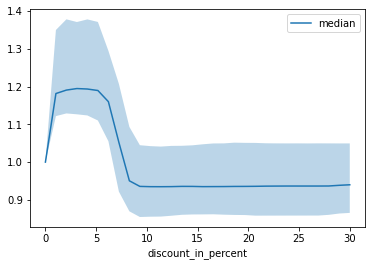

In [47]:
# graficando la mediana y el percentil 25% y 75%
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);